# Statistical Thinking in Python (Part 2)
- William Surles
- 2017-11-23
- Datacamp class
- [https://www.datacamp.com/courses/statistical-thinking-in-python-part-2](https://www.datacamp.com/courses/statistical-thinking-in-python-part-2)

## Whats Covered

**Parameter estimation by optimization**
- Optimal parameters
- Linear regression by least squares
- The importance of EDA: Anscombe's quartet

**Bootstrap confidence intervals**
- Generating bootstrap replicates
- Bootstrap confidence intervals
- Pairs bootstrap

**Introduction to hypothesis testing**
- Formulating and simulating a hypothesis
- Test statistics and p-values
- Bootstrap hypothesis tests

**Hypothesis test examples**
- A/B testing
- Test of correlation

**Putting it all together: a case study**
- Finch beaks and the need for statistics
- Variation of beak shapes
- Calculation of heritability
- Final thoughts

## Additional Resources

## Libraries and Data

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Useful Funcitons 

In [42]:

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

def plot_ecdf(x,y, x_label = 'Number of Successes', size = 5):
    """Plot the ECDF for a one-dimensional array of measurements."""
        
#     plt.figure(figsize=(16,10))
    plt.plot(
        x, y,
        marker = 'o',
        markersize = size,
        alpha = 0.7,
        linestyle = 'none')

    plt.margins(0.02)

    plt.xlabel(x_label)
    plt.ylabel('ECDF')

        
    return plt

def plot_hist_step(x, n_bins, x_label = 'Value'):
    """Plot the histogram for a one-dimensional array of measurements."""

    plt.figure(figsize=(16,10))
    plt.hist(
        x,
        bins = n_bins, 
        linewidth = 3,
        normed = True, 
        histtype = 'step')
    
    plt.xlabel(x_label)
    plt.ylabel('PDF')
    
    return plt

def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x,y)

    # Return entry [0,1]
    return corr_mat[0,1]

def plot_hist_and_stat(replicates, test_stat):
    
    # Make a histogram of the results
    plt.figure(figsize=(16,10))

    plt.hist(
        replicates, 
        edgecolor = 'k',
        bins = 35, 
        normed = True)

    plt.axvline(
        x = test_stat, 
        color = 'red', 
        linewidth = 3, 
        alpha = .8)

    plt.ylabel('PDF')
    
    return plt


# Parameter estimation by optimization

## Optimal parameters

- Parameter values that bring the model in closest agreement with the data
- The the case of michealsons speed of light data this is the actual mean and std from the dataset
- If your model is wrong, finding optimal parameters won't really matter much
- Finding the optimal parameters to model your data is not always as easy as just computing the mean and std
 - When we work with linear regressions later we will use built in numpy functions to find the optimal parameters for us
- There are some very useful tools in python for doing statistical inference
 - scipy.stats
 - statsmodels
- In this class however, we will use hacker statistics
 - This is like a swiss army knife of statistics
 - you can apply the principles to a wide variety of statistical problems

### How often do we get no-hitters?
- If you assume that no-hitters are described as a Poisson process, then the time between no-hitters is Exponentially distributed. 
- The exponential distribution has a single parameter $\tau{}$
- The value of the parameter $\tau{}$ that makes the exponential distribution best match the data is the mean interval time (where tim is in units of number of games) between no hitters.

In [43]:
file = 'https://assets.datacamp.com/production/course_1550/datasets/mlb_nohitters.csv'
no_hitters = pd.read_csv(file)
print(no_hitters.head())
print(no_hitters.tail())

       date  game_number winning_team losing_team winning_pitcher
0  18760715          140          NaN         NaN             NaN
1  18800612         1035          NaN         NaN             NaN
2  18800617         1046          NaN         NaN             NaN
3  18800819         1177          NaN         NaN             NaN
4  18800820         1179          NaN         NaN             NaN
         date  game_number winning_team losing_team  winning_pitcher
289  20150725       210250          PHI         CHN      Cole Hamels
290  20150812       210490          SEA         BAL  Hisashi Iwakuma
291  20150821       210610          HOU         LAN    Michael Fiers
292  20150830       210740          CHN         LAN     Jake Arrieta
293  20151003       211208          WAS         NYN     Max Scherzer


In [44]:
nohitter_times = no_hitters.game_number.diff(1)[1:]
nohitter_times[:6]

1    895.0
2     11.0
3    131.0
4      2.0
5    935.0
6     30.0
Name: game_number, dtype: float64

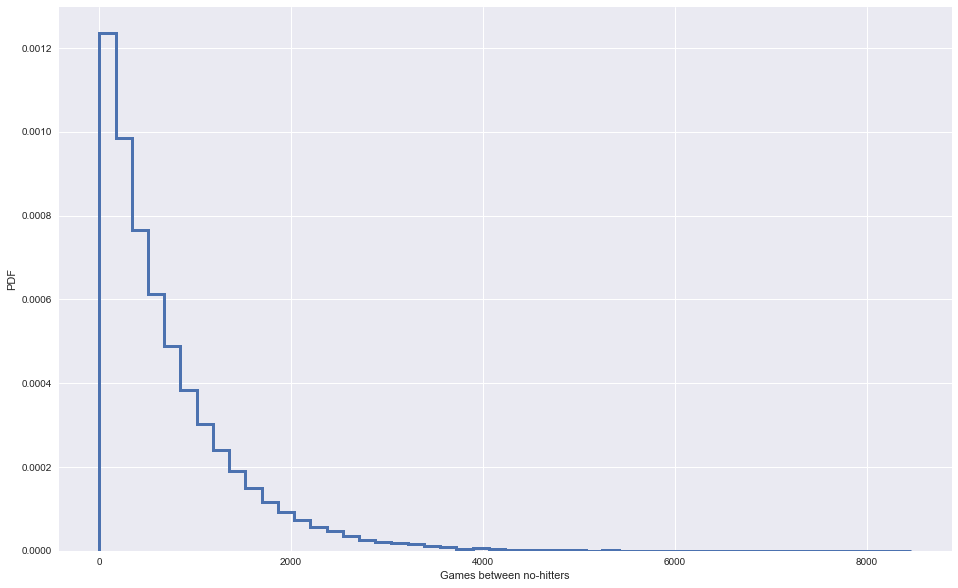

In [45]:
# Seed random number generator
np.random.seed(42)

# Compute mean no-hitter time: tau
tau = np.mean(nohitter_times)

# Draw out of an exponential distribution with parameter tau: inter_nohitter_time
inter_nohitter_time = np.random.exponential(tau, 100000)

# Plot the PDF and label axes
plot_hist_step(
    inter_nohitter_time, 
    n_bins = 50, 
    x_label = 'Games between no-hitters')

# Show the plot
plt.show()

### Do the data follow our story?

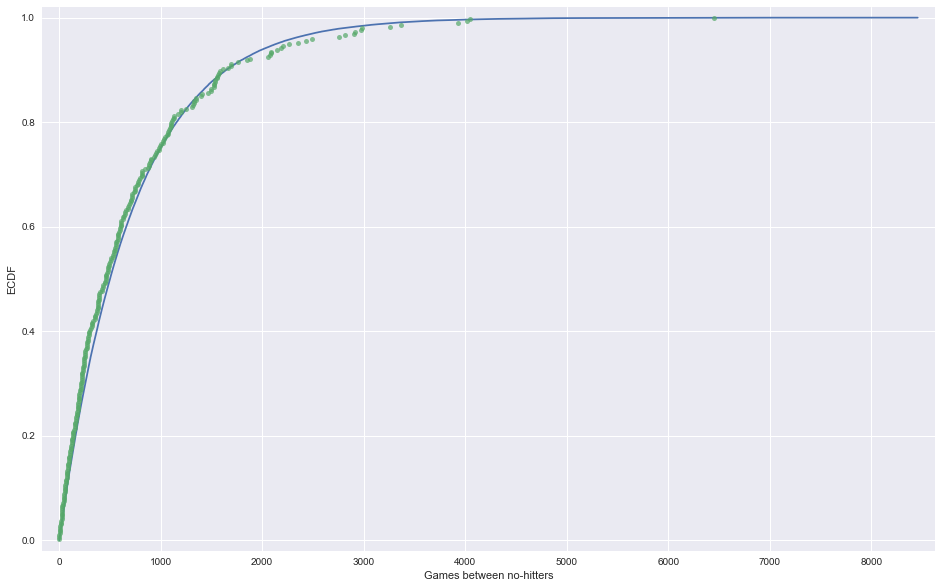

In [46]:
# Create an ECDF from real data: x, y
x, y = ecdf(nohitter_times)

# Create a CDF from theoretical samples: x_theor, y_theor
x_theor, y_theor = ecdf(inter_nohitter_time)

# Overlay the plots
plt.figure(figsize=(16,10))
plt.plot(x_theor, y_theor)
plot_ecdf(x,y, x_label = 'Games between no-hitters')


# Show the plot
plt.show()


### How is this parameter optimal?

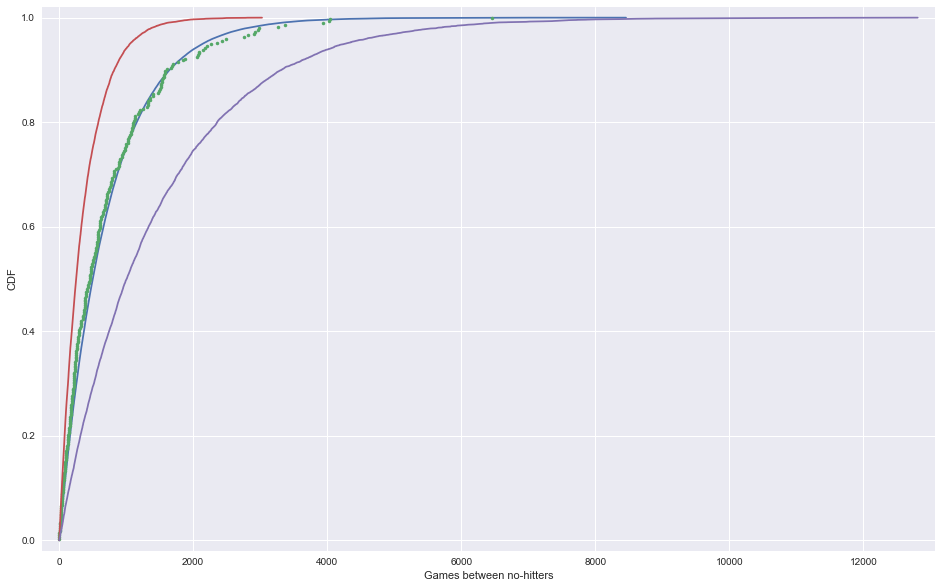

In [47]:
# Plot the theoretical CDFs
plt.figure(figsize=(16,10))
plt.plot(x_theor, y_theor)
plt.plot(x, y, marker='.', linestyle='none')
plt.margins(0.02)
plt.xlabel('Games between no-hitters')
plt.ylabel('CDF')

# Take samples with half tau: samples_half
samples_half = np.random.exponential(tau/2, 10000)

# Take samples with double tau: samples_double
samples_double = np.random.exponential(tau*2, 10000)

# Generate CDFs from these samples
x_half, y_half = ecdf(samples_half)
x_double, y_double = ecdf(samples_double)

# Plot these CDFs as lines
_ = plt.plot(x_half, y_half)
_ = plt.plot(x_double, y_double)

# Show the plot
plt.show()

## Linear regression by least squares

- Sometimes, two variable are related. : ) Ha!
- We can calculate a pearsons value which is a good start. 
- But we can go further and actually get a sense of what one value will be based on another
- In this case we can fit a model to describe what the y value will be based on the x value
- A linear regression is a simple common form of this
 - We find the line through the points where the vertical difference between the line and each point is minimized. We square all the differences and move the line around till we find the smallest value. 
 - This is ordinary least squares regression. Its the most common I believe
- You define the line with the y intercept and slope
- the slope tells you how much the y value changes for each increase in value for x
 - Thats pretty useful. 

### EDA of literacy/fertility data

In [48]:
file = 'https://assets.datacamp.com/production/course_1550/datasets/female_literacy_fertility.csv'
female = pd.read_csv(file)
female.head()

,Country,Continent,female literacy,fertility,population
0,Chine,ASI,90.5,1.769,"1,324,655,000"
1,Inde,ASI,50.8,2.682,"1,139,964,932"
2,USA,NAM,99.0,2.077,"304,060,000"
3,Indonésie,ASI,88.8,2.132,"227,345,082"
4,Brésil,LAT,90.2,1.827,"191,971,506"


In [49]:
illiteracy = 100 - female['female literacy']
fertility = female['fertility']

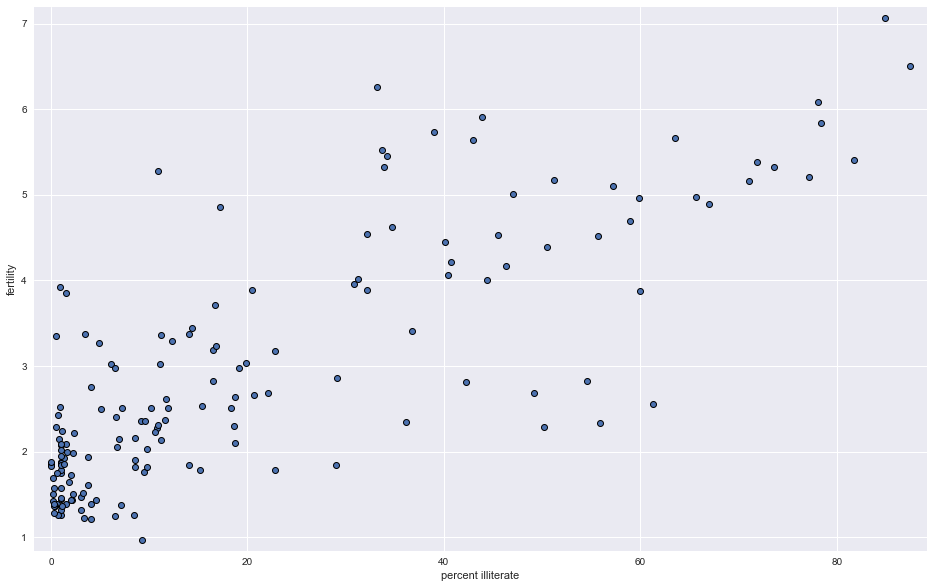

In [50]:
# Plot the illiteracy rate versus fertility
plt.figure(figsize=(16,10))
_ = plt.plot(
    illiteracy, fertility, 
    marker='o',
    markersize = 6,
    markeredgewidth = 1,
    markeredgecolor = 'k',
    linestyle='none')

# Set the margins and label axes
plt.margins(0.02)
_ = plt.xlabel('percent illiterate')
_ = plt.ylabel('fertility')

# Show the plot
plt.show()

In [51]:
# Show the Pearson correlation coefficient
print(pearson_r(illiteracy, fertility))

0.804132402682


### Linear regression

slope = 0.0497985480906 children per woman / percent illiterate
intercept = 1.88805061064 children per woman


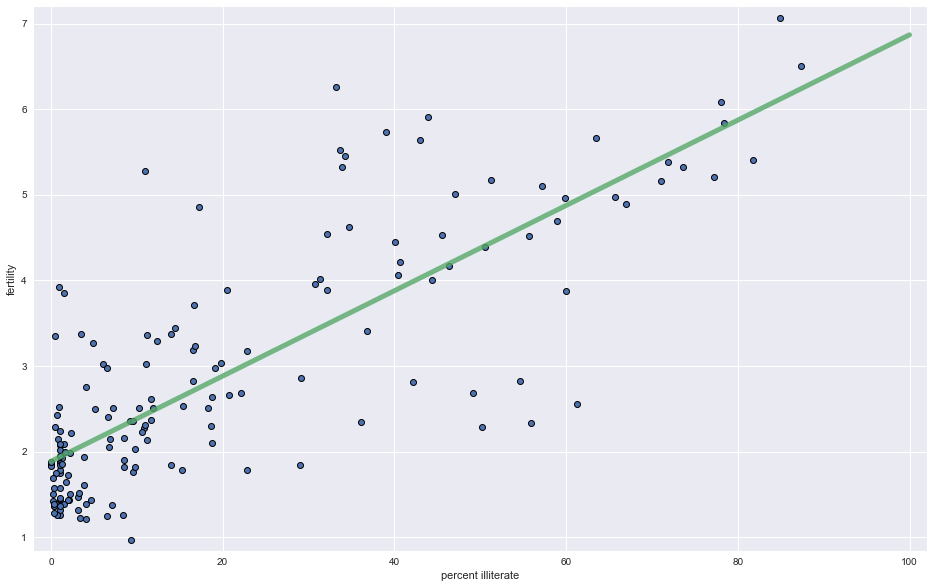

In [52]:
# Plot the illiteracy rate versus fertility
plt.figure(figsize=(16,10))
_ = plt.plot(
    illiteracy, fertility, 
    marker='o',
    markersize = 6,
    markeredgewidth = 1,
    markeredgecolor = 'k',
    linestyle='none')
plt.margins(0.02)
_ = plt.xlabel('percent illiterate')
_ = plt.ylabel('fertility')

# Perform a linear regression using np.polyfit(): a, b
a, b = np.polyfit(illiteracy, fertility, 1)

# Print the results to the screen
print('slope =', a, 'children per woman / percent illiterate')
print('intercept =', b, 'children per woman')

# Make theoretical line to plot
x = np.array([0, 100])
y = a * x + b

# Add regression line to your plot
_ = plt.plot(x, y, linewidth = 5, alpha = 0.8)

# Draw the plot
plt.show()


### How is it optimal?

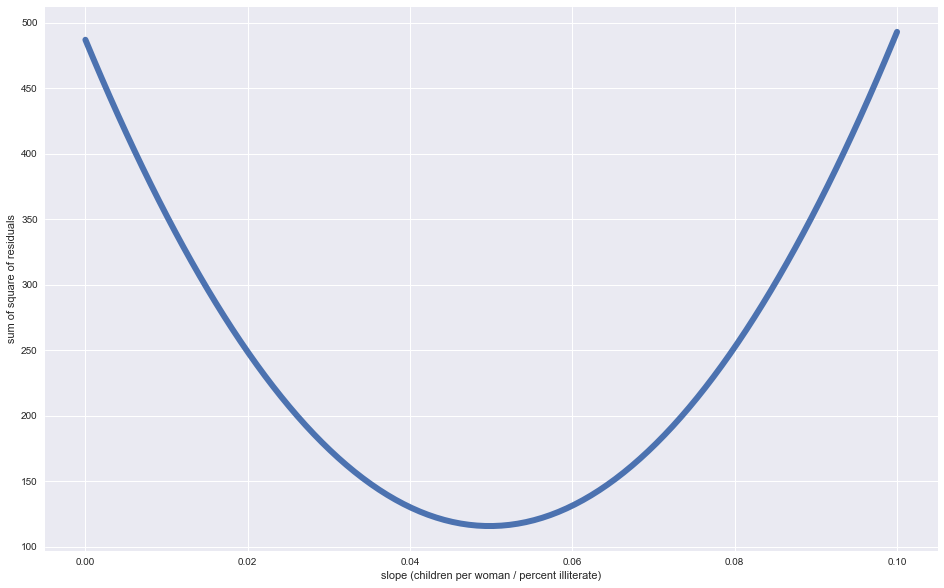

In [53]:
# Specify slopes to consider: a_vals
a_vals = np.linspace(0, 0.1, 200)

# Initialize sum of square of residuals: rss
rss = np.empty_like(a_vals)

# Compute sum of square of residuals for each value of a_vals
for i, a in enumerate(a_vals):
    rss[i] = np.sum((fertility - a*illiteracy - b)**2)

# Plot the RSS
plt.figure(figsize=(16,10))
plt.plot(a_vals, rss, '-', linewidth = 6)
plt.xlabel('slope (children per woman / percent illiterate)')
plt.ylabel('sum of square of residuals')

plt.show()


## The importance of EDA: Anscombe's quartet

- Look before you leap
- In Anscombe's quartet there are 4 data sets that all have the same x mean, y mean, regression line fit, and squarred error. Its awesome.

![](images/anscombe.png)

### The importance of EDA

- EDA helps you plan the rest of your analysis
- Its also very helpful to prevent misinterpretation like that showed by the Anscombe quartet
- It gives you a great sense of your data and is not very hard to do eaither.
- I think its helpful for those whoe will be recieving your analysis to help them understand the data, question, analysis, and answer. 

### Linear regression on appropriate Anscombe data

In [54]:
file = 'https://assets.datacamp.com/production/course_1550/datasets/anscombe.csv'
anscombe = pd.read_csv(file, skiprows = [0,1], names = ['x_0','y_0','x_1','y_1','x_2','y_2','x_3','y_3'])
anscombe.head()

,x_0,y_0,x_1,y_1,x_2,y_2,x_3,y_3
0,10.0,8.04,10.0,9.14,10.0,7.46,8.0,6.58
1,8.0,6.95,8.0,8.14,8.0,6.77,8.0,5.76
2,13.0,7.58,13.0,8.74,13.0,12.74,8.0,7.71
3,9.0,8.81,9.0,8.77,9.0,7.11,8.0,8.84
4,11.0,8.33,11.0,9.26,11.0,7.81,8.0,8.47


In [55]:
x = anscombe.x_0
y = anscombe.y_0

In [56]:
# Perform linear regression: a, b
a, b = np.polyfit(x,y,1)

# Print the slope and intercept
print(a, b)

0.500090909091 3.00009090909


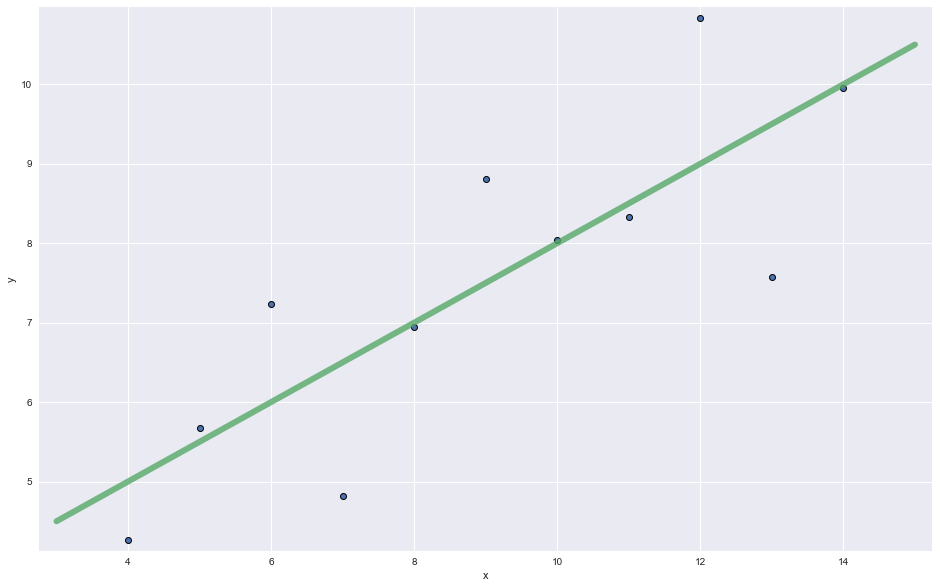

In [57]:
# Generate theoretical x and y data: x_theor, y_theor
x_theor = np.array([3, 15])
y_theor = a * x_theor + b

# Plot the Anscombe data and theoretical line
plt.figure(figsize=(16,10))
_ = plt.plot(
    x, y, 
    marker='o',
    markersize = 6,
    markeredgewidth = 1,
    markeredgecolor = 'k',
    linestyle='none')

_ = plt.plot(x_theor, y_theor, linewidth = 6, alpha = 0.8)

# Label the axes
plt.xlabel('x')
plt.ylabel('y')
plt.margins(0.02)

# Show the plot
plt.show()

### Linear regression on all Anscombe data

In [58]:
anscombe_x = anscombe.iloc[:,[0,2,4,6]]
anscombe_y = anscombe.iloc[:,[1,3,5,7]]

In [59]:
# Iterate through x,y pairs
for x, y in zip(anscombe_x, anscombe_y):

    # Compute the slope and intercept: a, b
    a, b = np.polyfit(anscombe_x[x], anscombe_y[y], 1)

    # Print the result
    print('slope:', a, 'intercept:', b)


slope: 0.500090909091 intercept: 3.00009090909
slope: 0.5 intercept: 3.00090909091
slope: 0.499727272727 intercept: 3.00245454545
slope: 0.499909090909 intercept: 3.00172727273


# Bootstrap confidence intervals

## Generating bootstrap replicates

- you take a sample of measured data (like the speed of light from experiments)
- then you create a new **bootstrap sample** that is the same length of the original array
 - you sample a value at random from the original dataset and put it in the bootstrap sample
 - repeat this until the bootstrap sample is full
 - you do not delete the value from the original array once it is selected in the bootstrap sample (unless you are doing it "without" replacement. 
 - but this will just give you the same original array but in a random order.

### Getting the terminology down

- A bootsrap replicate is a single value of a statistic computed from a bootstrap resample. Like a mean
- Terminology is important. "Bootstrap" gets used in many ways in the coding community so be sure to define terminioloy when you are talking about these things.

### Bootstrapping by hand

- [-1, 0, 1]
- How many unique bootstrap samples can be drawn from this dataset. 
 - 27, because we use replacement 3 * 3 * 3
- What is the maximum mean you can get
 - 1 from [1, 1, 1]

### Visualizing bootstrap samples
- They use the speed of light data but I don't have access to that so I am just going to use rainfall
- Now i see that they use the rainfall data for their exercises so we will see this twice I guess. oh well

In [60]:
file = 'https://assets.datacamp.com/production/course_1550/datasets/sheffield_weather_station.csv'
weather = pd.read_csv(file, sep = '\s+', skiprows = 8, index_col = 'yyyy', parse_dates = False)
# anscombe = pd.read_csv(file, skiprows = [0,1], names = ['x_0','y_0','x_1','y_1','x_2','y_2','x_3','y_3'])
weather.head()

,mm,tmax,tmin,af,rain,sun
yyyy,,,,,,
1883,1,6.3,1.7,6,122.1,---
1883,2,8.0,2.8,2,69.8,---
1883,3,4.8,-1.6,23,29.6,---
1883,4,12.2,3.8,2,74.0,---
1883,5,14.7,6.2,0,31.2,---


In [61]:
rainfall = weather.groupby('yyyy')['rain'].sum()

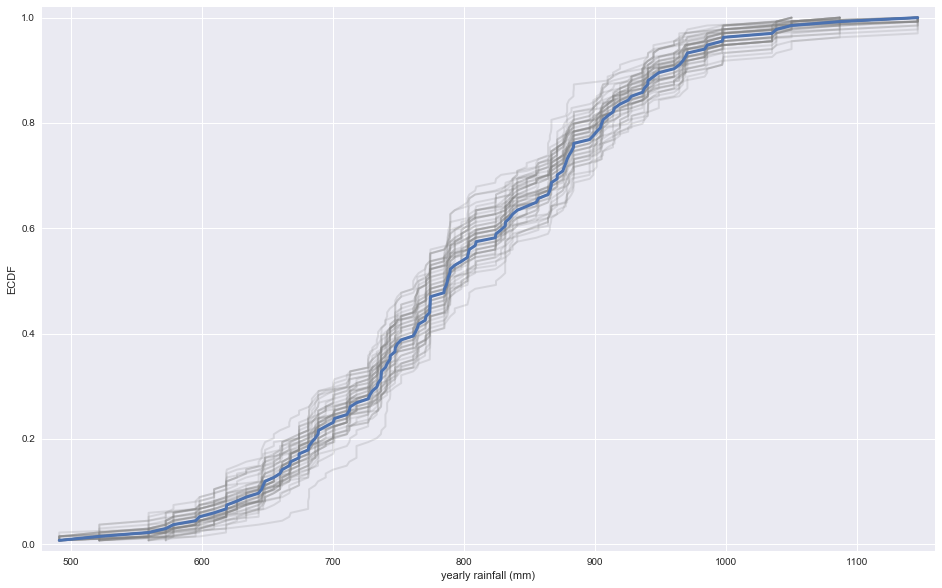

In [62]:
plt.figure(figsize=(16,10))

for _ in range(50):
    # Generate bootstrap sample: bs_sample
    bs_sample = np.random.choice(rainfall, size=len(rainfall))

    # Compute and plot ECDF from bootstrap sample
    x, y = ecdf(bs_sample)
    _ = plt.plot(
        x, y, 
        linestyle='-',
        linewidth = 2,
        color='gray', 
        alpha=0.2)

# Compute and plot ECDF from original data
x, y = ecdf(rainfall)
_ = plt.plot(x, y, linewidth = 3)

# Make margins and label axes
plt.margins(0.02)
_ = plt.xlabel('yearly rainfall (mm)')
_ = plt.ylabel('ECDF')

# Show the plot
plt.show()


## Bootstrap confidence intervals

#### Bootstrap replicate function
 - this is pretty simple
 - just take a bootrap sample and compute the mean or median or any function for a stastic

In [63]:
def bootstrap_replicate_1d(data, func):
    """generate bootstrap replicate of 1D data"""
    
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

In [64]:
print(np.mean(rainfall))
print(bootstrap_replicate_1d(rainfall, np.mean))
print(bootstrap_replicate_1d(rainfall, np.mean))
print(bootstrap_replicate_1d(rainfall, np.mean))
print(bootstrap_replicate_1d(rainfall, np.mean))

798.014179104
797.264925373
803.085074627
801.694776119
806.364925373


#### Many bootstrap replicates

In [65]:
bs_replicates = np.empty(10000)

for i in range(10000):
    bs_replicates[i] = bootstrap_replicate_1d(rainfall, np.mean)

#### Ploting a histogram of bootstrap replicates

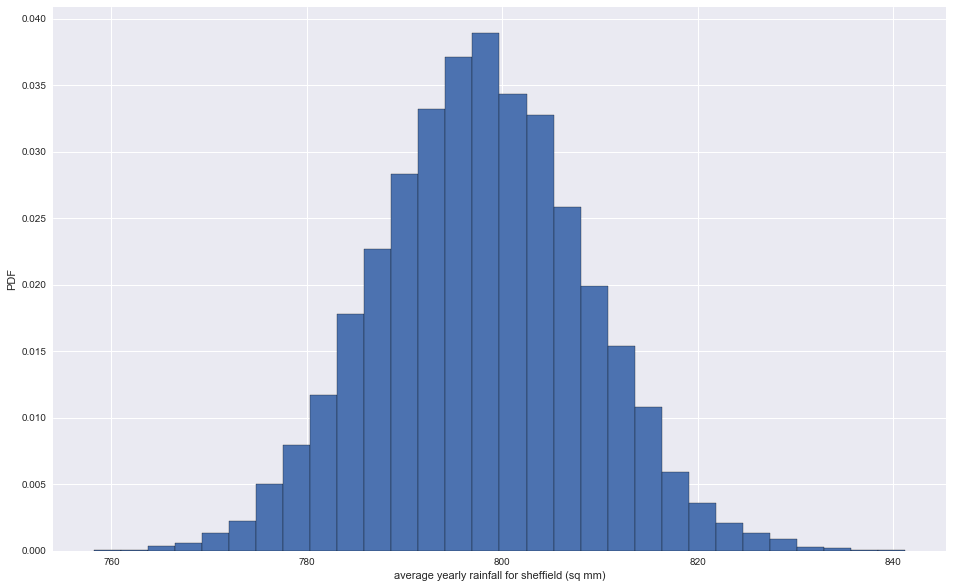

In [66]:
plt.figure(figsize=(16,10))
plt.hist(
    bs_replicates, 
    edgecolor = 'k',
    bins = 30, 
    normed = True)
plt.xlabel('average yearly rainfall for sheffield (sq mm)')
plt.ylabel('PDF')
plt.show()

- So, from eying the pdf, if we were to capture the yearly rainfall for sheffield over and over again (which is something we cannot do becasuse we can't go back in time to rerun this experiment) we would expect to see a mean from 1983 to 2016 of say 798 +/- 20 inches. 
- Lets figure this out with a little more statistic rigor. What is the mean yearly rainfall for sheffield, for real?

#### Confidence interval of a statistic
- If we repeated measurements over and over agian, p% of the observed values would lie within the p% confidence interval. 
- In other words if we were run an experiment 100 times and take the mean, 95 of the mean values would be within the 95% confidence interval

In [67]:
mean = np.mean(bs_replicates)
conf_int = np.percentile(bs_replicates, [2.5, 97.5])
print("mean = " + str(mean))
print("95 % conf int = " + str(conf_int))
print('-----------------------')
print("So I would say I am 95% ceratin that the mean is... " + str(mean) + " +/- " + str((conf_int[1] - conf_int[0])/2) + " sq mm")

mean = 797.851752313
95 % conf int = [ 777.33192164  818.82936567]
-----------------------
So I would say I am 95% ceratin that the mean is... 797.851752313 +/- 20.7487220149 sq mm


### Generating many bootstrap replicates

In [68]:
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates


### Bootstrap replicates of the mean and the SEM

10.6354581308
10.5930220051


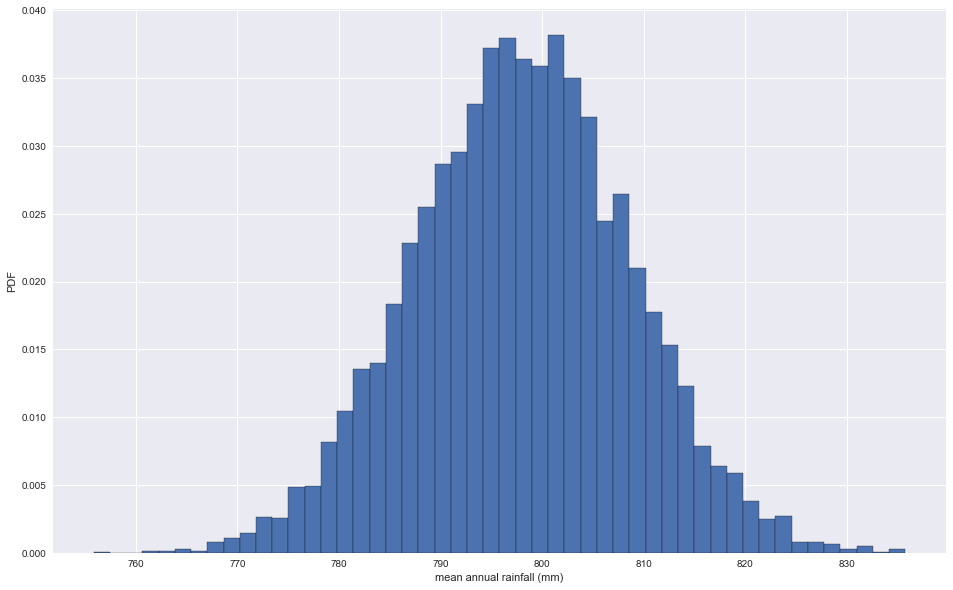

In [69]:
# Take 10,000 bootstrap replicates of the mean: bs_replicates
bs_replicates = draw_bs_reps(rainfall, np.mean, 10000)

# Compute and print SEM
sem = np.std(rainfall) / np.sqrt(len(rainfall))
print(sem)

# Compute and print standard deviation of bootstrap replicates
bs_std = np.std(bs_replicates)
print(bs_std)

# Make a histogram of the results
plt.figure(figsize=(16,10))
_ = plt.hist(
    bs_replicates, 
    edgecolor = 'k',
    bins = 50, 
    normed = True)
_ = plt.xlabel('mean annual rainfall (mm)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

### Confidence intervals of rainfall data

In [70]:
np.percentile(bs_replicates, [2.5, 97.5])

array([ 777.16337687,  818.77761194])

### Bootstrap replicates of other statistics

- We saw in a previous exercise that the mean is Normally distributed. 
- This does not necessarily hold for other statistics
 - but no worry: as hackers, we can always take bootstrap replicates! 

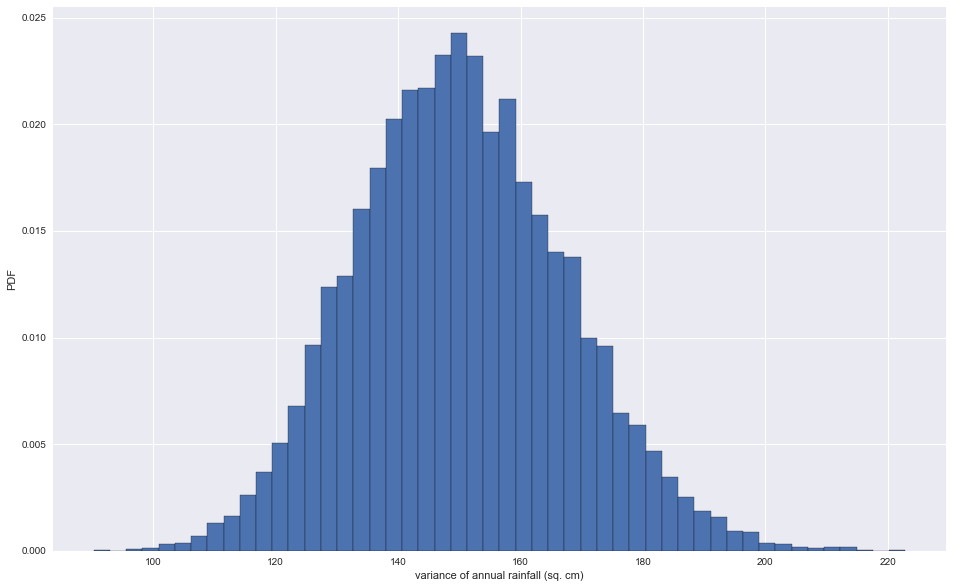

In [71]:
# Generate 10,000 bootstrap replicates of the variance: bs_replicates
bs_replicates = draw_bs_reps(rainfall, np.var, size=10000)

# Put the variance in units of square centimeters
bs_replicates /= 100

# Make a histogram of the results
plt.figure(figsize=(16,10))
_ = plt.hist(
    bs_replicates, 
    edgecolor = 'k',
    bins = 50, 
    normed = True)
_ = plt.xlabel('variance of annual rainfall (sq. cm)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()


### Confidence interval on the rate of no-hitters

95% confidence interval = [ 628.20298635  817.49846416] games


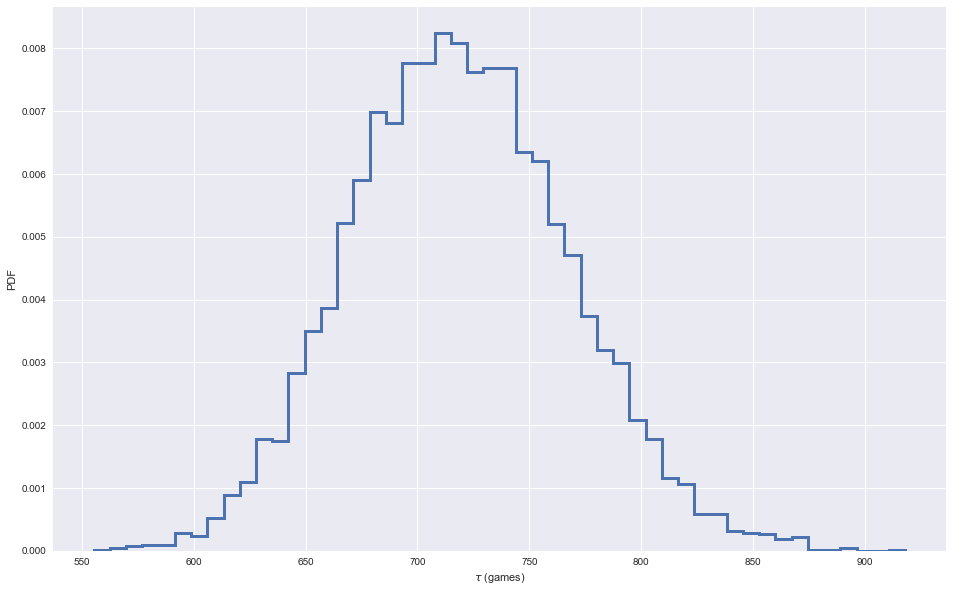

In [72]:
# Draw bootstrap replicates of the mean no-hitter time (equal to tau): bs_replicates
bs_replicates = draw_bs_reps(nohitter_times, np.mean, 10000)

# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(bs_replicates, [2.5, 97.5])

# Print the confidence interval
print('95% confidence interval =', conf_int, 'games')

# Plot the histogram of the replicates
plot_hist_step(bs_replicates, n_bins = 50, x_label = r'$\tau$ (games)')

# Show the plot
plt.show()


## Pairs bootstrap

- We want to think probabilisticly about our linear model from before
- We can't resample voter number and obama percents separately, becasue the data are paired
- So we sample pairs, or the points basically
- Its pretty easy, we just sample the indicies of the dataframe or arrays

### A function to do pairs bootstrap

In [153]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps


### Pairs bootstrap of literacy/fertility data

[ 0.04387789  0.0556481 ]


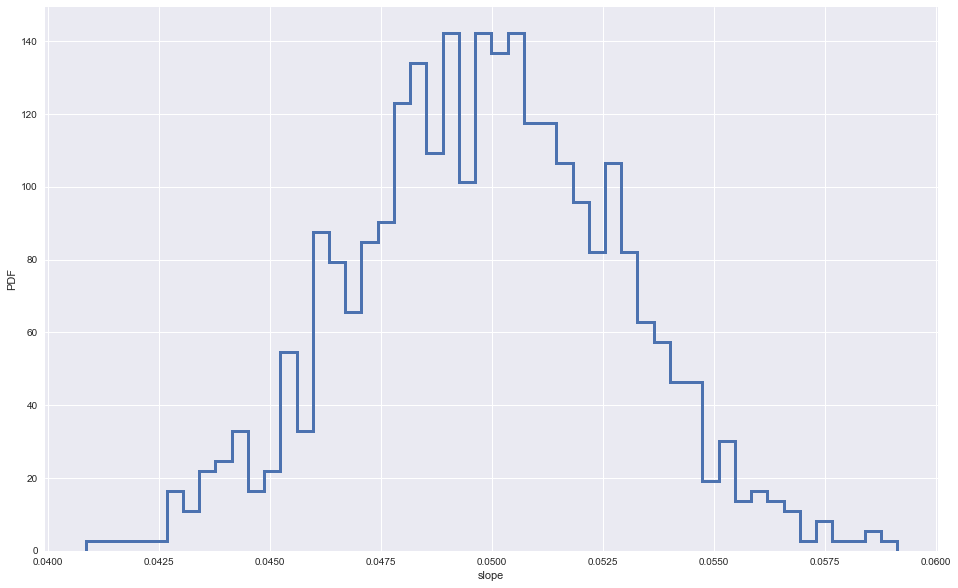

In [157]:
# Generate replicates of slope and intercept using pairs bootstrap
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(illiteracy, fertility, size = 1000)

# Compute and print 95% CI for slope
print(np.percentile(bs_slope_reps, [2.5, 97.5]))

# Plot the histogram
plot_hist_step(bs_slope_reps, 50, 'slope')
plt.show()

### Plotting bootstrap regressions

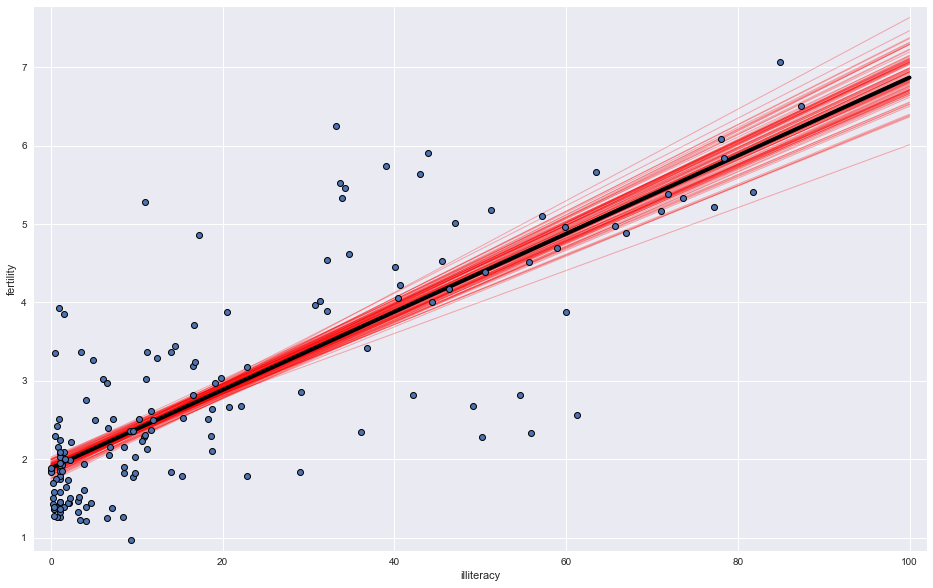

In [75]:
# Generate array of x-values for bootstrap lines: x
x = np.array([0,100])

plt.figure(figsize=(16,10))

# Plot the bootstrap lines
for i in range(100):
    _ = plt.plot(
        x, 
        bs_slope_reps[i]*x + bs_intercept_reps[i],
        linewidth=1, 
        alpha=0.3, 
        color='red')

# Plot the original regression line
# Make theoretical line to plot
a, b = np.polyfit(illiteracy, fertility, 1)
y = a * x + b

# Add regression line to your plot
_ = plt.plot(
    x, y,
    linewidth=4,  
    color='black')

# Plot the data
_ = plt.plot(
    illiteracy, fertility,
    marker='o',
    markersize = 6,
    markeredgewidth = 1,
    markeredgecolor = 'k',
    linestyle='none')

# Label axes, set the margins, and show the plot
_ = plt.xlabel('illiteracy')
_ = plt.ylabel('fertility')
plt.margins(0.02)
plt.show()

# Introduction to hypotheis testing

## Formulating and simulating a hypothesis

- Hypothesis testing
 - Assessment of how reasonabole the observed data are assiming a hypthesis is true
- Null Hypothesis
 - Another name for the hypothesis you are testing
- The hypthesis the instructor makes
 - Ohio and Pennsylvania have the same normal distribution
 - Looking at the ecdf they definitely look close
 - same for summary statistics
- But to know for sure we can re-simulate the election with scrambled values between the two labels
 - They call this 'permutation'
 - We will cover how to generate a permutation sample
 - I have seen this called 'shuffling' before
 

### Generating a permutation sample
- Remember, a permutation sample of two arrays having respectively n1 and n2 entries is constructed by: 
 - concatenating the arrays together, 
 - scrambling the contents of the concatenated array, 
 - and then taking the first n1 entries as the permutation sample of the first array 
 - and the last n2 entries as the permutation sample of the second array.

In [76]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

### Visualizing permutation sampling

In [77]:
weather.head(24)

,mm,tmax,tmin,af,rain,sun
yyyy,,,,,,
1883,1,6.3,1.7,6,122.1,---
1883,2,8.0,2.8,2,69.8,---
1883,3,4.8,-1.6,23,29.6,---
1883,4,12.2,3.8,2,74.0,---
1883,5,14.7,6.2,0,31.2,---
1883,6,17.7,9.3,0,66.2,---
1883,7,18.8,10.5,0,77.6,---
1883,8,19.8,10.9,0,32.5,---
1883,9,16.8,10.0,0,137.4,---


In [78]:
rain_july = weather.rain[weather.mm == 7]
rain_november = weather.rain[weather.mm == 11]

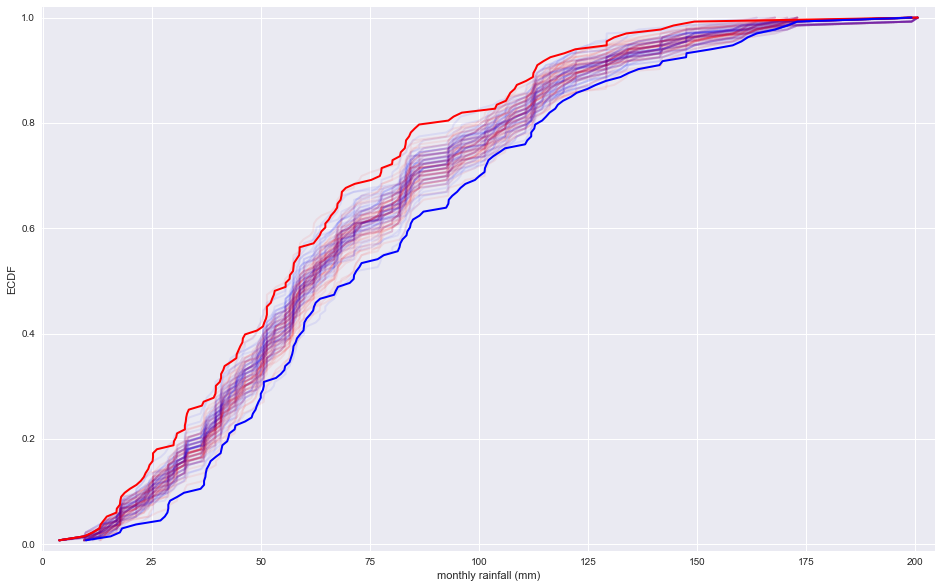

In [79]:
plt.figure(figsize=(16,10))

for _ in range(50):
    # Generate permutation samples
    perm_sample_1, perm_sample_2 = permutation_sample(rain_july, rain_november)

    # Compute ECDFs
    x_1, y_1 = ecdf(perm_sample_1)
    x_2, y_2 = ecdf(perm_sample_2)

    # Plot ECDFs of permutation sample
    _ = plt.plot(
        x_1, y_1, 
        linestyle='-',
        linewidth = 2,
        color='red', 
        alpha=0.07)
    
    _ = plt.plot(
        x_2, y_2, 
        linestyle='-',
        linewidth = 2,
        color='blue', 
        alpha=0.07)
    
# Create and plot ECDFs from original data
x_1, y_1 = ecdf(rain_july)
x_2, y_2 = ecdf(rain_november)
_ = plt.plot(x_1, y_1, linestyle='-', linewidth = 2, color='red')
_ = plt.plot(x_2, y_2, linestyle='-', linewidth = 2, color='blue')

# Label axes, set margin, and show plot
plt.margins(0.02)
_ = plt.xlabel('monthly rainfall (mm)')
_ = plt.ylabel('ECDF')
plt.show()

## Test statistics and p-values

- So is the rain fall in the two months (july and november) differnet?
 - Or is the percent vote for obama by county different in Ohio and Penn?
- To answer this concretely we will use a hypothesis test on a test statistic, like the mean
- test statistic
 - A single number that can be computed from observed data and form data you simulate under the null hypothesis
 - It serves as a basis of comparison between the two
- p-value
 - The probability of obtaining a value of your test statistic that is at least as extreme as what was observed, under the the assumption the null hypothesis is true
 - NOT the prbability that the null hypothesis is true

For me, this is all much easier to understand when I see it
- Basically we make a hypthesis that rainfall in july and november is different
- then we say the null hypothesis is that they are the same
- then we run a bunch of samples assumping the the null hypothesis is true. 
 - i.e. we shuffle labels and measure the statistic, 
 - or in this case, the difference in the statistic, so the differnece in means between the two shuffled samples
- then we see how often we get a test statistic more extreme than what we had from the original samples
 - if its less than .05 percent of the time then we reject the null hypothesis, which is just to say. we accept the hypothesis that the original samples come from different distributions. 
 - so yeah, it rains more in november. : ) 
 - the 0.05 can be whatever, thats just a classic place to draw the line.
- anyways, lets just do it

### Test statistics

- When performing hypothesis tests, your choice of test statistic should be:
 - pertinent to the question you are seeking to answer in your hypothesis test.

### What is a p-value?

- The p-value is generally a measure of:
 - the probability of observing a test statistic equally or more extreme than the one you observed, assuming the hypothesis you are testing is true.

### Generating permutation replicates

In [80]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

### Look before you leap: EDA before hypothesis testing

In [81]:
file = 'https://assets.datacamp.com/production/course_1550/datasets/frog_tongue.csv'
df = pd.read_csv(file, skiprows = 14)
df.head()

,date,ID,trial number,impact force (mN),impact time (ms),impact force / body weight,adhesive force (mN),time frog pulls on target (ms),adhesive force / body weight,adhesive impulse (N-s),total contact area (mm2),contact area without mucus (mm2),contact area with mucus / contact area without mucus,contact pressure (Pa),adhesive strength (Pa)
0,2013_02_26,I,3,1205,46,1.95,-785,884,1.27,-0.290,387,70,0.82,3117,-2030
1,2013_02_26,I,4,2527,44,4.08,-983,248,1.59,-0.181,101,94,0.07,24923,-9695
2,2013_03_01,I,1,1745,34,2.82,-850,211,1.37,-0.157,83,79,0.05,21020,-10239
3,2013_03_01,I,2,1556,41,2.51,-455,1025,0.74,-0.170,330,158,0.52,4718,-1381
4,2013_03_01,I,3,493,36,0.80,-974,499,1.57,-0.423,245,216,0.12,2012,-3975


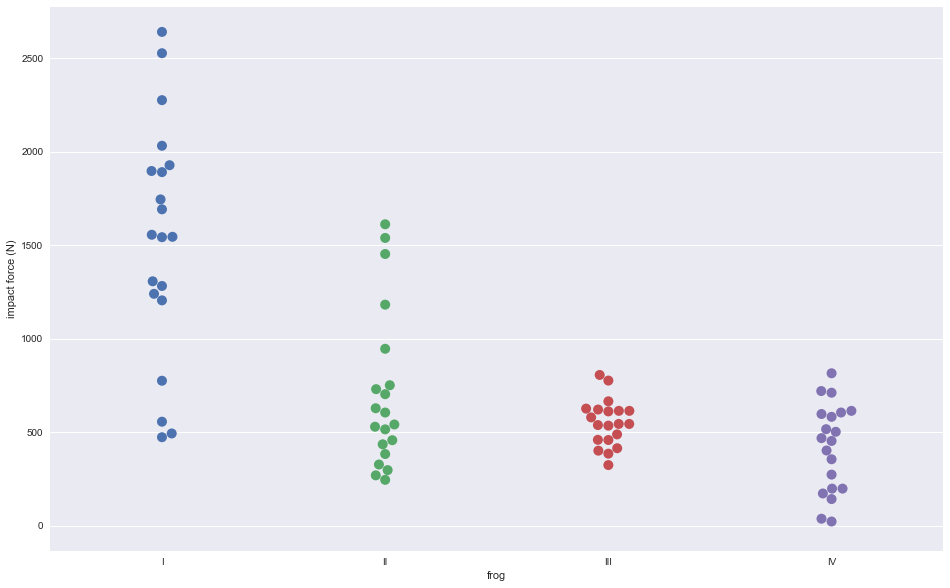

In [82]:
plt.figure(figsize=(16,10))

# Make bee swarm plot
_ = sns.swarmplot(
    x = 'ID', 
    y = 'impact force (mN)', 
    data = df,
    size = 10)

# Label axes
_ = plt.xlabel('frog')
_ = plt.ylabel('impact force (N)')

# Show the plot
plt.show()


### Permutation test on frog data

In [83]:
force_a = df['impact force (mN)'][df['ID'] == 'II']
force_b = df['impact force (mN)'][df['ID'] == 'IV']

In [84]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

In [85]:
# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(force_a, force_b)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(force_a, force_b,
                                 diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# Print the result
print('p-value =', p)

p-value = 0.004


- This is pretty small suggesting that the populations are different
 - Its not totally out there, like 0.0000000005
 - but enough for us to say adult frogs have stronger tounges than adolesent frogs
- I think it helps to show the distribution so let me try to do that. 

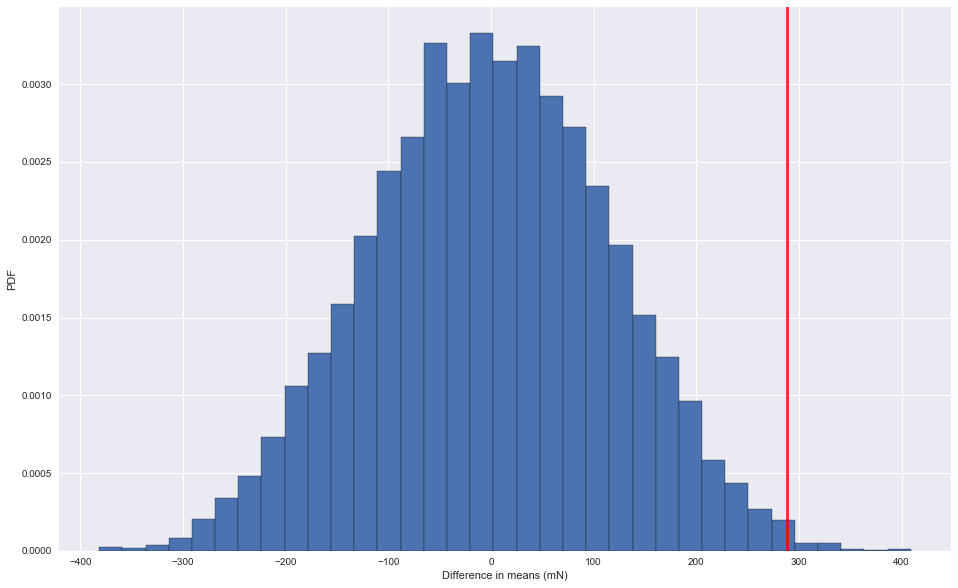

In [86]:
# Make a histogram of the results
plot_hist_and_stat(perm_replicates, empirical_diff_means)
plt.xlabel('Difference in means (mN)')
plt.show()

## Bootstrap hypothesis tests

#### Pipeline for hypothesis testing
- Clearly state the null hypothesis
- Define your test statistic
- Generate many sets of simulated data assuming the null hypothesis is true
- Compute the test statistic for each simulated data set
- The p-value is the fraction of your simulated data sets for which the test statistic is at least as extreme as for the real data


In [87]:
file = 'https://assets.datacamp.com/production/course_1549/datasets/michelson_speed_of_light.csv'
light = pd.read_csv(file)
light.head()

,Unnamed: 0,date,distinctness of image,temperature (F),position of deflected image,position of slit,displacement of image in divisions,difference between greatest and least,B,Cor,revolutions per second,radius (ft),value of one turn of screw,velocity of light in air (km/s),remarks
0,0,June 5,3,76,114.85,0.300,114.55,0.17,1.423,-0.132,257.36,28.672,0.99614,299850,Electric light.
1,1,June 7,2,72,114.64,0.074,114.56,0.10,1.533,-0.084,257.52,28.655,0.99614,299740,P.M. Frame inclined at various angles
2,2,June 7,2,72,114.58,0.074,114.50,0.08,1.533,-0.084,257.52,28.647,0.99614,299900,P.M. Frame inclined at various angles
3,3,June 7,2,72,85.91,0.074,85.84,0.12,1.533,-0.084,193.14,28.647,0.99598,300070,P.M. Frame inclined at various angles
4,4,June 7,2,72,85.97,0.074,85.89,O.07,1.533,-0.084,193.14,28.650,0.99598,299930,P.M. Frame inclined at various angles


In [88]:
speed_of_light = light['velocity of light in air (km/s)']
speed_of_light[:6]

0    299850
1    299740
2    299900
3    300070
4    299930
5    299850
Name: velocity of light in air (km/s), dtype: int64

In [89]:
mean = np.mean(speed_of_light)
print(mean)

299852.4


#### Comparing Michelson and Newcomb: speed of light pioneers
- Michelson's mean = 299,852
- Newcomb's mean = 299,860
- Thats a differnce of 8 km/s
- Also, newcomb did share his data. (I guess he hadn't hear of reproducible research yet)

#### Our Null Hypothesis
- The true mean speed of light in Michelson's experiments was actually Newcomb's reported value
- To test this we will shift michelson's data so the mean is the same as newcomb's
 - Then we will simulate a bunch of samples and see if getting 299852 is likely or not. 

#### Shifting the Michelson data

In [90]:
newcomb_value = 299860
michelson_shifted = speed_of_light - np.mean(speed_of_light) + newcomb_value

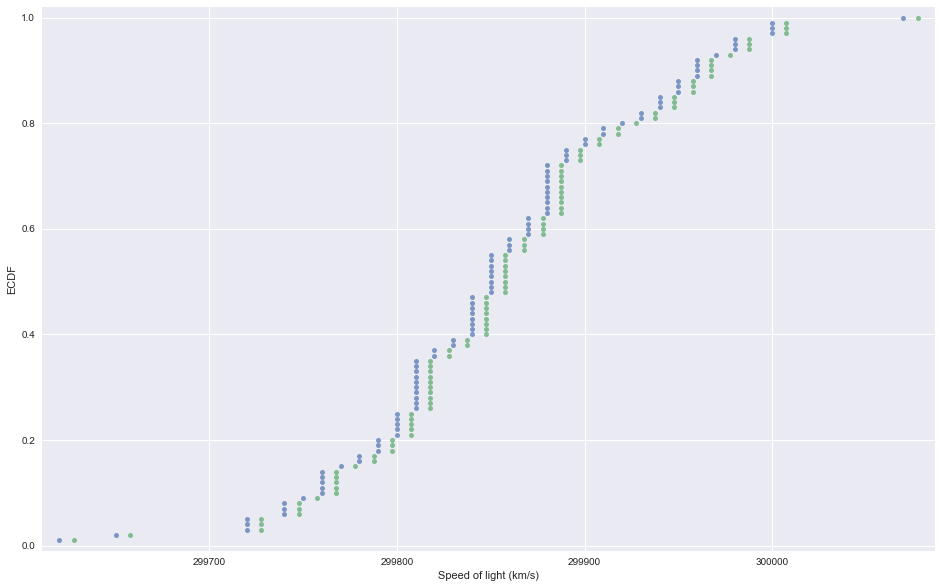

In [91]:
x_orig, y_orig = ecdf(speed_of_light)
x_shift, y_shift = ecdf(michelson_shifted)

plt.figure(figsize=(16,10))

plot_ecdf(x_orig, y_orig, 'Speed of light (km/s)')
plot_ecdf(x_shift, y_shift, 'Speed of light (km/s)')

# Make margins and label axes
plt.margins(0.02)
plt.xlabel('Speed of light (km/s)')
plt.ylabel('ECDF')

# Show the plot
plt.show()


#### Calculating the test statistic
- So this is just the differnce in means from our our speed of light data and the shifted dataset

In [92]:
def diff_from_newcomb(data, newcomb_value = 299860):
    return np.mean(data) - newcomb_value

In [93]:
diff_obs = diff_from_newcomb(speed_of_light)

diff_obs

-7.5999999999767169

#### Computing the p-value
- We will simulate 10000 samples from the null hypothesis dataset
- we will calculate the test statistic for each bootsrap sample
- we will calculate the p-value of the test statistic

In [94]:
bs_replicates = draw_bs_reps(michelson_shifted, diff_from_newcomb, 10000)

p_value = np.sum(bs_replicates <= diff_obs) / 10000
p_value

0.16700000000000001

#### Lets visualize this

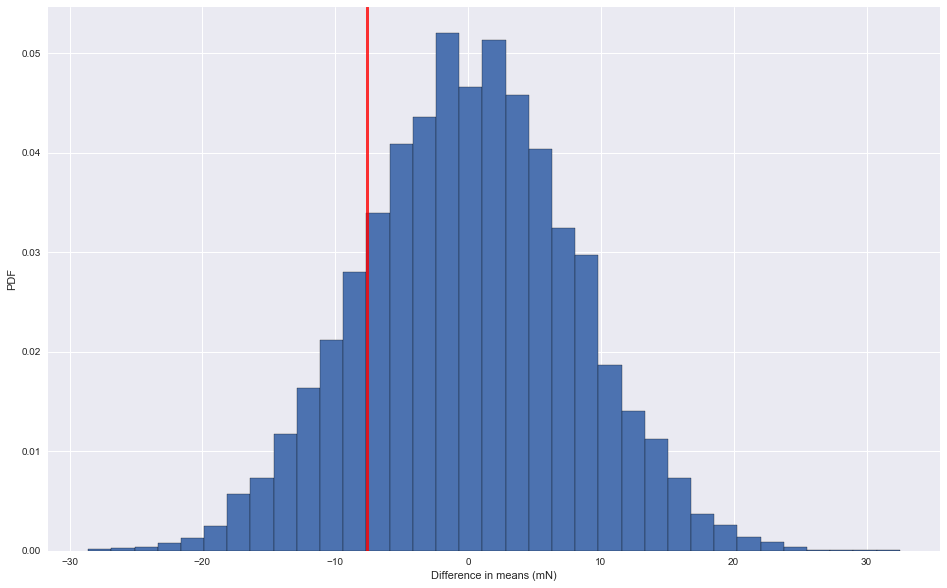

In [95]:
# Make a histogram of the results
plot_hist_and_stat(bs_replicates, diff_obs)
plt.xlabel('Difference in means (mN)')
plt.show()

#### Conclusion
- Thats not very unlikely
- We can conclude that the mean of Michelsons data did not differ from the mean of Newcombs data
- I think that because we don't have newcombs data we can't actually make claims about them coming from the same population. 
 -I'm not exactly sure yest how that statics jargon works

#### One vs Two sample test
- One sample test
 - compare one set of data to a single number
 - This is what we just did
- Two sample test
 - Compare two sets of data

### A one-sample bootstrap hypothesis test
- Another juvenile frog was studied, Frog C, and you want to see if Frog B and Frog C have similar impact forces.  
 - Unfortunately, you do not have Frog C's impact forces available, but you know they have a mean of 0.55 N. 
 - Because you don't have the original data, you cannot do a permutation test, and you cannot assess the hypothesis that the forces from Frog B and Frog C come from the same distribution. 
 - You will therefore test another, less restrictive hypothesis: The mean strike force of Frog B is equal to that of Frog C.
- To set up the bootstrap hypothesis test, you will take the mean as our test statistic. 
- Remember, your goal is to calculate the probability of getting a mean impact force less than or equal to what was observed for Frog B _if the hypothesis that the true mean of Frog B's impact forces is equal to that of Frog C is true._ 
- You first translate all of the data of Frog B such that the mean is 0.55 N. 
 - This involves adding the mean force of Frog C and subtracting the mean force of Frog B from each measurement of Frog B. 
 - This leaves other properties of Frog B's distribution, such as the variance, unchanged.

In [96]:
np.mean(force_b)

419.10000000000002

In [97]:
# Make an array of translated impact forces: translated_force_b
translated_force_b = force_b - np.mean(force_b) + 550
translated_force_b

60    302.9
61    272.9
62    167.9
63    583.9
64    485.9
65    152.9
66    632.9
67    403.9
68    850.9
69    712.9
70    328.9
71    328.9
72    727.9
73    646.9
74    945.9
75    532.9
76    735.9
77    841.9
78    744.9
79    598.9
Name: impact force (mN), dtype: float64

In [98]:
# Take bootstrap replicates of Frog B's translated impact forces: bs_replicates
bs_replicates = draw_bs_reps(translated_force_b, np.mean, 10000)
bs_replicates[:6]

array([ 439.25,  534.55,  489.55,  566.4 ,  568.25,  547.75])

In [99]:
# Compute fraction of replicates that are less than the observed Frog B force: p
p = np.sum(bs_replicates <= np.mean(force_b)) / 10000

# Print the p-value
print('p = ', p)

p =  0.0052


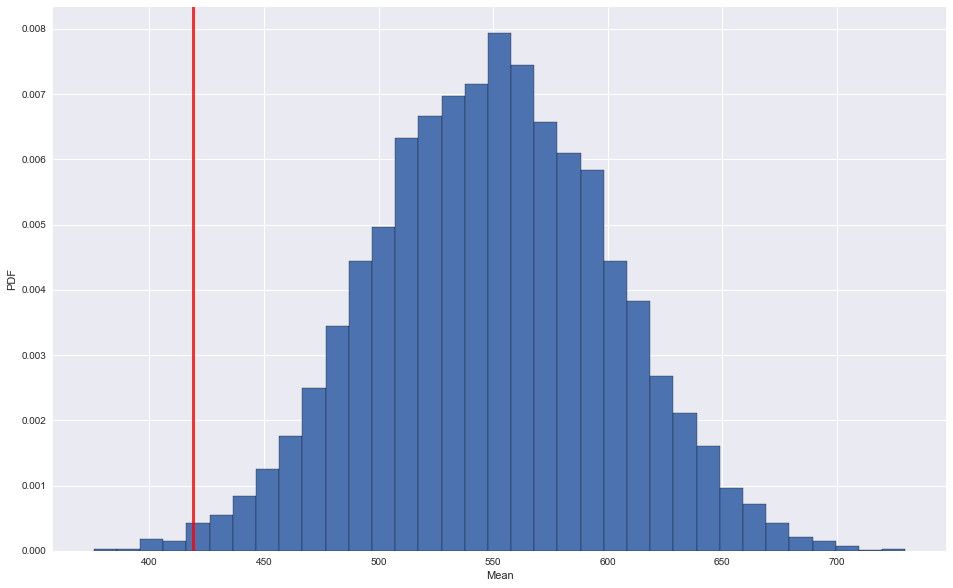

In [100]:
# Make a histogram of the results
plot_hist_and_stat(bs_replicates, np.mean(force_b))
plt.xlabel('Mean')
plt.show()

### A bootstrap test for identical distributions

In [101]:
# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(force_a, force_b)

# Concatenate forces: forces_concat
forces_concat = np.concatenate([force_a, force_b])

# Initialize bootstrap replicates: bs_replicates
bs_replicates = np.empty(10000)

for i in range(10000):
    # Generate bootstrap sample
    bs_sample = np.random.choice(
        forces_concat, 
        size=len(forces_concat))
    
    # Compute replicate
    bs_replicates[i] = diff_of_means(bs_sample[:len(force_a)],
                                     bs_sample[len(force_a):])

# Compute and print p-value: p
p = np.sum(bs_replicates >= empirical_diff_means) / len(bs_replicates)
print('p-value =', p)


p-value = 0.0065


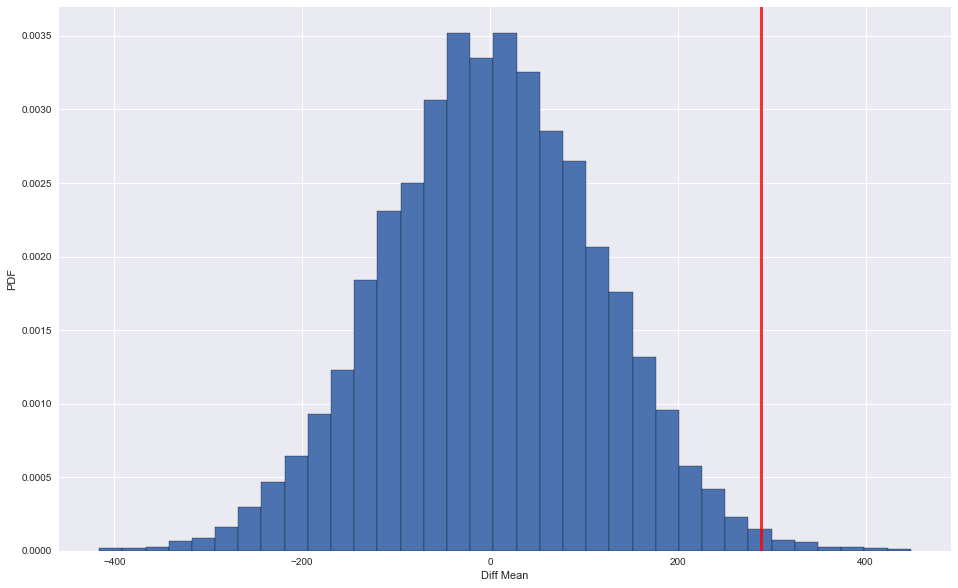

In [102]:
# Make a histogram of the results
plot_hist_and_stat(bs_replicates, empirical_diff_means)
plt.xlabel('Diff Mean')
plt.show()

- Great work! 
- You may remember that we got p = 0.0051 from the permutation test, and here we got p = 0.0067. 
- These are very close, and indeed the tests are testing the same thing. 
- However, the permutation test exactly simulates the null hypothesis that the data come from the same distribution, whereas the bootstrap test approximately simulates it. 
- As we will see, though, the bootstrap hypothesis test, while approximate, is more versatile.

### A two-sample bootstrap hypothesis test for difference of means.

**What the difference between shuffling (permutation) and bootstrapping**
- You performed a one-sample bootstrap hypothesis test, which is impossible to do with permutation. 
- Testing the hypothesis that two samples have the same distribution may be done with a bootstrap test, but a permutation test is preferred because it is more accurate (exact, in fact). 
- But therein lies the limit of a permutation test; it is not very versatile. 
- We now want to test the hypothesis that Frog A and Frog B have the same mean impact force, but not necessarily the same distribution. 
- This, too, is impossible with a permutation test.

**How we do a bootstrap test of the means being different**
- To do the two-sample bootstrap test, we shift both arrays to have the same mean, since we are simulating the hypothesis that their means are, in fact, equal. 
- We then draw bootstrap samples out of the shifted arrays and compute the difference in means. 
- This constitutes a bootstrap replicate, and we generate many of them. 
- The p-value is the fraction of replicates with a difference in means greater than or equal to what was observed.

In [103]:
# Compute mean of all forces: mean_force
mean_force = np.mean(forces_concat)

# Generate shifted arrays
force_a_shifted = force_a - np.mean(force_a) + mean_force
force_b_shifted = force_b - np.mean(force_b) + mean_force 

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_a = draw_bs_reps(force_a_shifted, np.mean, 10000)
bs_replicates_b = draw_bs_reps(force_b_shifted, np.mean, 10000)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_a - bs_replicates_b

# Compute and print p-value: p
p = np.sum(bs_replicates >= empirical_diff_means) / len(bs_replicates)
print('p-value =', p)


p-value = 0.0055


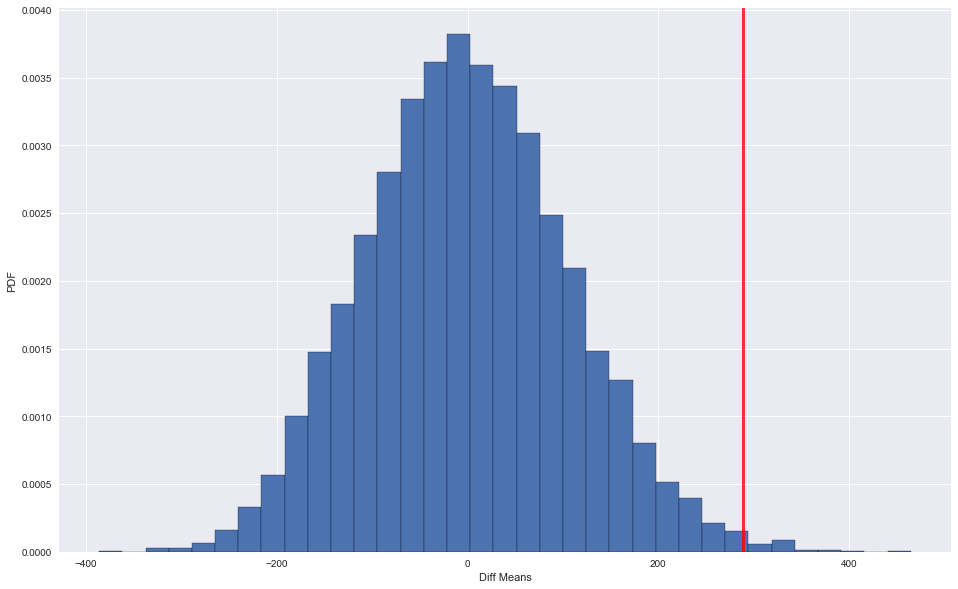

In [104]:
# Make a histogram of the results
plot_hist_and_stat(bs_replicates, empirical_diff_means)
plt.xlabel('Diff Means')
plt.show()

 - Not surprisingly, the more forgiving hypothesis, only that the means are equal as opposed to having identical distributions, gives a smaller p-value. 
 - Again, it is important to carefully think about what question you want to ask. 
 - Are you only interested in the mean impact force, or the distribution of impact forces?

# Hypothesis test examples

## A/B testing

### The vote for the Civil Rights Act in 1964

In [105]:
# Construct arrays of data: dems, reps
dems = np.array([True] * 153 + [False] * 91)
reps = np.array([True] * 136 + [False] * 35)

def frac_yay_dems(dems, reps):
    """Compute fraction of Democrat yay votes."""
    frac = np.sum(dems) / len(dems)
    return frac

# Acquire permutation samples: perm_replicates
perm_replicates = draw_perm_reps(dems, reps, frac_yay_dems, 10000)

# Compute and print p-value: p
p = np.sum(perm_replicates <= 153/244) / len(perm_replicates)
print('p-value =', p)


p-value = 0.0001


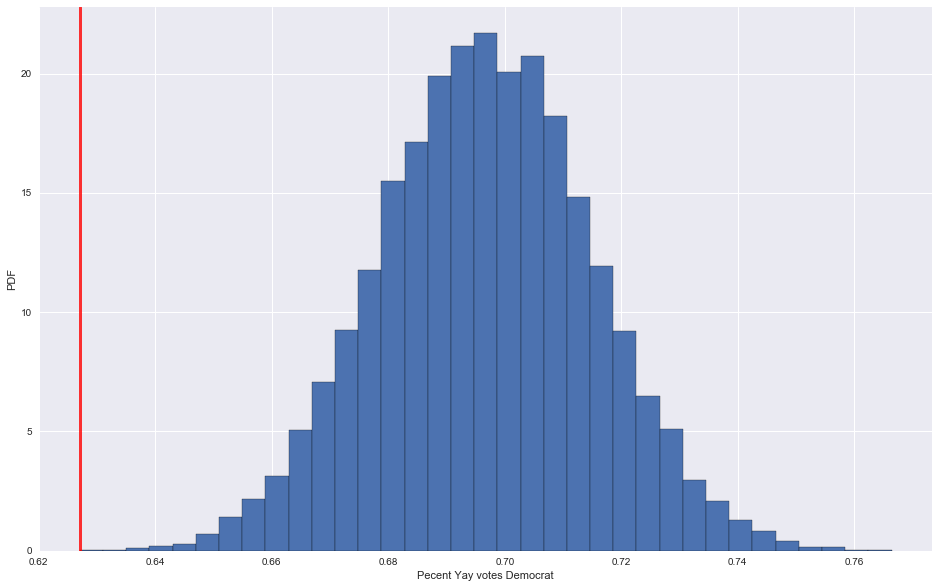

In [106]:
# Make a histogram of the results
plot_hist_and_stat(perm_replicates, 153/244)
plt.xlabel('Pecent Yay votes Democrat')
plt.show()

### What is equivalent?

- This is similar to doing an A/B test where you measure 'yes' votes or actions (like clicking on an add) before and after a change. 
 - You remove the before after labels with the permutation and see what the distribution of percent yes actions looks like if there is no difference. 
 - Then compare that to the yes percent of the group after the change. 
 - In another scenario this could be two versions of an email or an add that are run at the same time. Its kind of the same as the before after case, if you assume nothing has changed except the feature.
- In our case it is not a before after label, but a dem or rep label. 
 - Its still a percent of population doing an action A/B test. 
- There are other types of AB test that incolve the number of times users do something before and after a change. Or on different versions of a thing. 
- There are also test where you measure the amount of time on a website. 
- Depending on your site and what you want from the users you can choose many different things as the test statistic. 
 - I believe the process will be the same though. 
 - Here it would be a time spend or difference in time spent. 

### A time-on-website analog

In [107]:
no_hitters.head()

,date,game_number,winning_team,losing_team,winning_pitcher
0,18760715,140,NaN,NaN,NaN
1,18800612,1035,NaN,NaN,NaN
2,18800617,1046,NaN,NaN,NaN
3,18800819,1177,NaN,NaN,NaN
4,18800820,1179,NaN,NaN,NaN


In [108]:
no_hitter_dead = no_hitters[no_hitters.date < 19200101]
no_hitter_live = no_hitters[no_hitters.date >= 19200101]

In [109]:
nht_dead = no_hitter_dead.game_number.diff(1)[1:]
nht_live = no_hitter_live.game_number.diff(1)[1:]

In [110]:
# Compute the observed difference in mean inter-no-hitter times: nht_diff_obs
nht_diff_obs = diff_of_means(nht_dead, nht_live)

# Acquire 10,000 permutation replicates of difference in mean no-hitter time: perm_replicates
perm_replicates = draw_perm_reps(
    nht_dead, nht_live, 
    diff_of_means,
    10000)


# Compute and print the p-value: p
p = np.sum(perm_replicates <= nht_diff_obs) / len(perm_replicates)
print('p-val =',p)


p-val = 0.0001


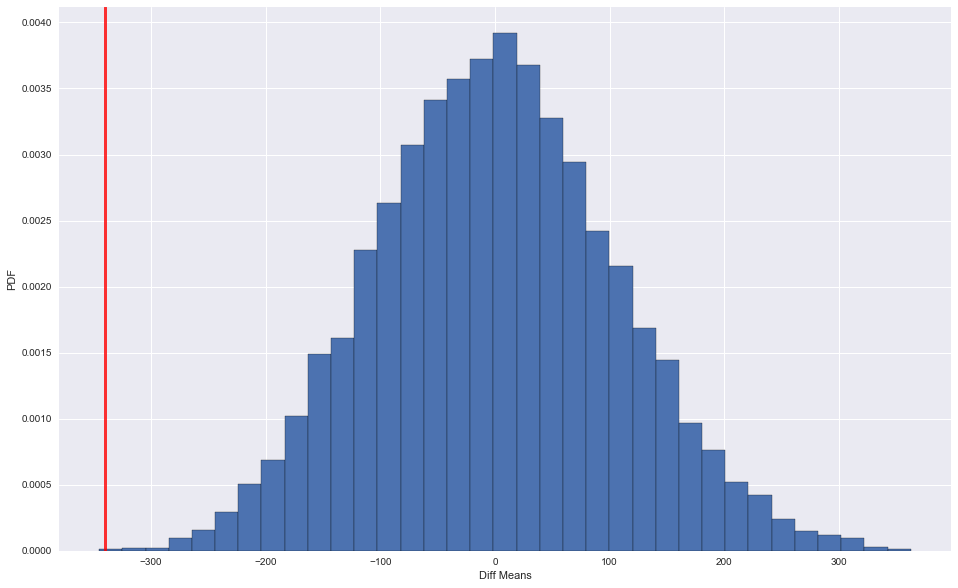

In [111]:
# Make a histogram of the results
plot_hist_and_stat(perm_replicates, nht_diff_obs)
plt.xlabel('Diff Means')
plt.show()

- There was probably just one scenario where the obs_diff was more extreme.
 - It could have been zero or two. It would be the same result. Very unlikely. 
 - So the changes definitely made a difference in the average time between no hitters. 

### What should you have done first?

- EDA to see the ecdf of the two time periods. Or something to get a sense for the distribution in the data. 
 - In fact, let me just do that now. 

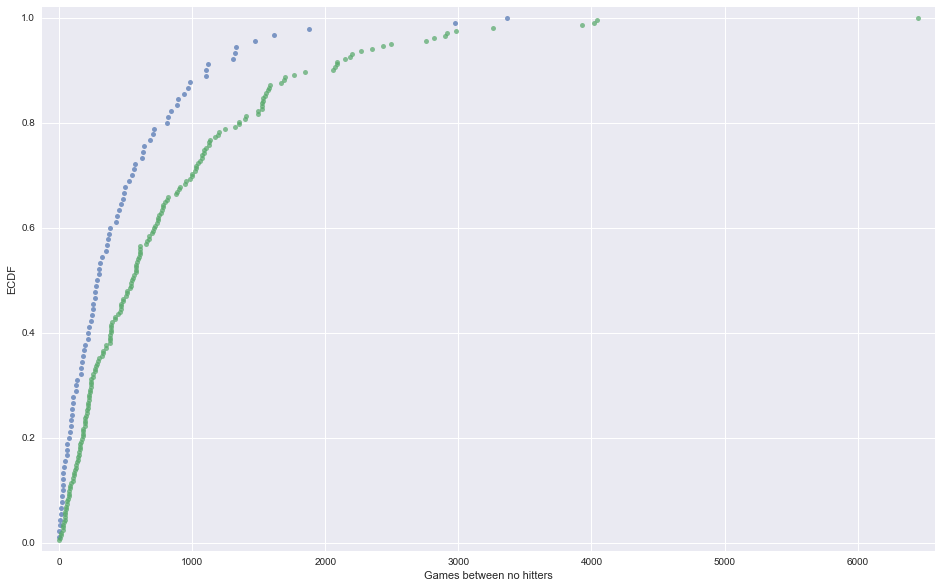

In [112]:
x_1, y_1 = ecdf(nht_dead)
x_2, y_2 = ecdf(nht_live)

plt.figure(figsize=(16,10))

plot_ecdf(x_1, y_1, 'Speed of light (km/s)')
plot_ecdf(x_2, y_2, 'Speed of light (km/s)')

# Make margins and label axes
plt.margins(0.02)
plt.xlabel('Games between no hitters')
plt.ylabel('ECDF')

# Show the plot
plt.show()


- These are intereting ecdf curves as they do not have the lower tail. They seem more exponential. But it is still clear that there was a shift that made the games between the no hitters higher
 - It also looks like there may have been more games in the live era, which makes sense because there is much more time in that era.

## Test of correlation

### Simulating a null hypothesis concerning correlation

- To permute this pairs data set we will just permute the y-values. This should randomize things and give us no correlation with the x-values.
- As you will see the r_obs centers around 0 and is ralrely highter than 0.2
- This also means that anything above 0.2 probably means there is a correlation in the data in general. : ) 

### Hypothesis test on Pearson correlation
- this is a bit slow because we gennerate the 10k samples in a for loop. 

In [113]:
# Compute observed correlation: r_obs
r_obs = pearson_r(illiteracy, fertility)

# Initialize permutation replicates: perm_replicates
perm_replicates = np.empty(10000)

# Draw replicates
for i in range(10000):
    # Permute illiteracy measurments: illiteracy_permuted
    illiteracy_permuted = np.random.permutation(illiteracy)

    # Compute Pearson correlation
    perm_replicates[i] = pearson_r(illiteracy_permuted, fertility)

# Compute p-value: p
p = np.sum(perm_replicates >= r_obs) / len(perm_replicates)
print('p-val =', p)

p-val = 0.0


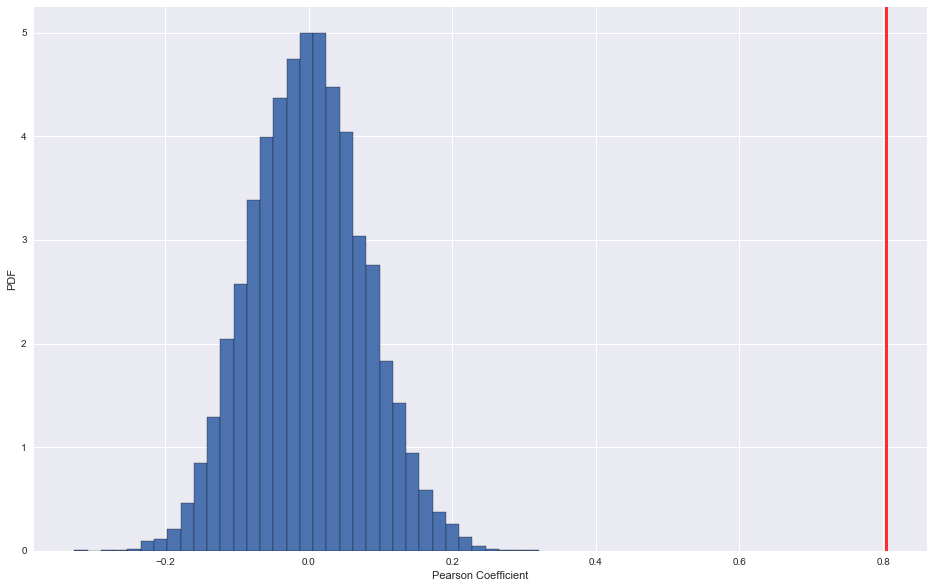

In [114]:
# Make a histogram of the results
plot_hist_and_stat(perm_replicates, r_obs)
plt.xlabel('Pearson Coefficient')
plt.show()

- Nothing is even close. There is clearly a legit correlation. 
 - Theoretically if we ran enough samples, like probably millions and millions in this case, we would get something that was above our `r_obs` and then we would have a very very small p-value. 
 - But 10k is plenty. We have a p-value of 0 becasue nothing is as extremer as our original test statistic. We have enough data to answer the question practically. Larger cities definitely were more likely to vote for obama.

### Do neonicotinoid insecticides have unintended consequences?

In [115]:
file = 'https://assets.datacamp.com/production/course_1550/datasets/bee_sperm.csv'
bee = pd.read_csv(file, skiprows = 3)
bee.head()

,Specimen,Treatment,Environment,TreatmentNCSS,Sample ID,Colony,Cage,Sample,Sperm Volume per 500 ul,Quantity,ViabilityRaw (%),Quality,Age (d),Infertil,AliveSperm,Quantity Millions,Alive Sperm Millions,Dead Sperm Millions
0,227,Control,Cage,1,C2-1-1,2,1,1,2150000,2150000,96.7263814616756,96.726381,14,0,2079617,2.1500,2.079617,0.070383
1,228,Control,Cage,1,C2-1-2,2,1,2,2287500,2287500,96.3498079760595,96.349808,14,0,2204001,2.2875,2.204001,0.083499
2,229,Control,Cage,1,C2-1-3,2,1,3,87500,87500,98.75,98.750000,14,0,86406,0.0875,0.086406,0.001094
3,230,Control,Cage,1,C2-1-4,2,1,4,1875000,1875000,93.2874208336941,93.287421,14,0,1749139,1.8750,1.749139,0.125861
4,231,Control,Cage,1,C2-1-5,2,1,5,1587500,1587500,97.7925061050061,97.792506,14,0,1552456,1.5875,1.552456,0.035044


In [116]:
control = bee['Alive Sperm Millions'][bee.Treatment == 'Control']
treated = bee['Alive Sperm Millions'][bee.Treatment == 'Pesticide']

In [117]:
print(bee.shape)
print(len(control))
print(len(treated))

(235, 18)
145
90


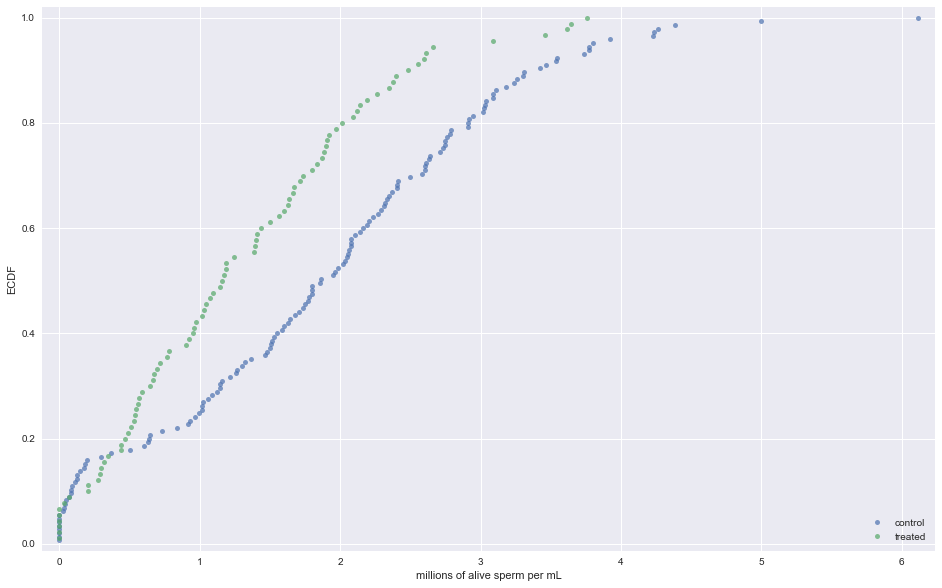

In [118]:
# Compute x,y values for ECDFs
x_control, y_control = ecdf(control)
x_treated, y_treated = ecdf(treated)

# Plot the ECDFs
plt.figure(figsize=(16,10))
plot_ecdf(x_control, y_control)
plot_ecdf(x_treated, y_treated)

# Set the margins
plt.margins(0.02)

# Add a legend
plt.legend(('control', 'treated'), loc='lower right')

# Label axes and show plot
plt.xlabel('millions of alive sperm per mL')
plt.ylabel('ECDF')
plt.show()


- Its an interesting ECDF, especially at the bottom. 
 - Some bees have zero in both groups, weird.
 - Then the control has more lower sperm cases, I don't know whats going on there. 
 - But around half a million, the effects of the pesticide really start to show. 

### Bootstrap hypothesis test on bee sperm counts

In [119]:
# Compute the difference in mean sperm count: diff_means
diff_means = np.mean(control) - np.mean(treated)

# Compute mean of pooled data: mean_count
mean_count = np.mean(np.concatenate((control, treated)))

# Generate shifted data sets
control_shifted = control - np.mean(control) + mean_count
treated_shifted = treated - np.mean(treated) + mean_count

# Generate bootstrap replicates
bs_reps_control = draw_bs_reps(control_shifted,
                               np.mean, size=10000)
bs_reps_treated = draw_bs_reps(treated_shifted,
                               np.mean, size=10000)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_reps_control - bs_reps_treated

# Compute and print p-value: p
p = np.sum(bs_replicates >= np.mean(control) - np.mean(treated)) \
            / len(bs_replicates)
print('p-value =', p)


p-value = 0.0


In [120]:
print(np.mean(control))
print(np.mean(treated))
print(diff_means)

1.87277707586
1.29974771111
0.573029364751


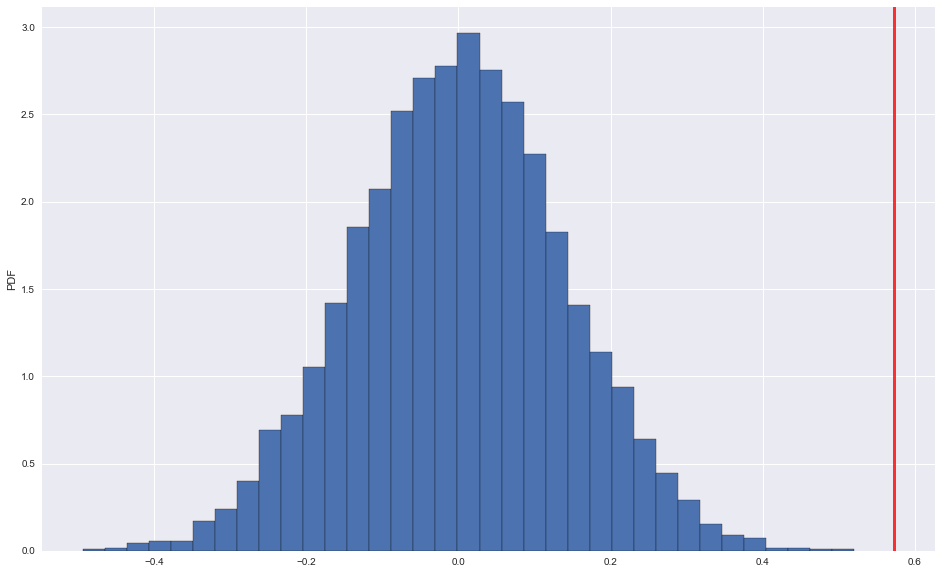

In [121]:
plot_hist_and_stat(bs_replicates, diff_means)
plt.show()

# Putting it all together: a case study

## Finch beaks and the need for statistics

#### What we can do so far
- Graphical and quantitative EDA
- Parameter estimation
- Confidence interval calculation
- Hypothesis testing

#### The dataset
- Peter and Rosemary Grant
 - 40 Years of Evolution: Darwin's Finches on Daphne Major Island, Princeton University Press, 2014
 - Data acquired from Dryad Digital Repository h p://dx.doi.org/10.5061/dryad.g6g3h
 - Finch beak measurements
 - length and depth
 - 1975 to 2012
 - Two species, fortis and scandens, on a small volcanic island, Daphne Major

#### Investigation
 - EDA of beak depths in 1975 and 2012
 - Parameter estimates of mean beak depth
 - Hypothesis test: did the beaks get deeper?

### EDA of beak depths of Darwin's finches

In [122]:
file_1975 = 'https://assets.datacamp.com/production/course_1550/datasets/finch_beaks_1975.csv'
finch_1975 = pd.read_csv(file_1975)
finch_1975.head()

,band,species,"Beak length, mm","Beak depth, mm"
0,2,fortis,9.4,8.0
1,9,fortis,9.2,8.3
2,12,fortis,9.5,7.5
3,15,fortis,9.5,8.0
4,305,fortis,11.5,9.9


In [123]:
file_2012 = 'https://assets.datacamp.com/production/course_1550/datasets/finch_beaks_2012.csv'
finch_2012 = pd.read_csv(file_2012)
finch_2012.head()

,band,species,blength,bdepth
0,19022,fortis,10.0,8.5
1,19028,fortis,12.5,8.9
2,19032,fortis,9.3,7.5
3,19041,fortis,10.3,9.6
4,19044,fortis,11.0,9.2


In [124]:
finch_2012.species.unique()

array(['fortis', 'scandens'], dtype=object)

In [125]:
bd_1975 = finch_1975['Beak depth, mm'][finch_1975.species == 'scandens']
bd_2012 = finch_2012['bdepth'][finch_2012.species == 'scandens']

In [126]:
bl_1975 = finch_1975['Beak length, mm'][finch_1975.species == 'scandens']
bl_2012 = finch_2012['blength'][finch_2012.species == 'scandens']

In [127]:
print(finch_1975.shape)
print(len(bd_1975))
print('-------------')
print(finch_2012.shape)
print(len(bd_2012))

(403, 4)
87
-------------
(248, 4)
127


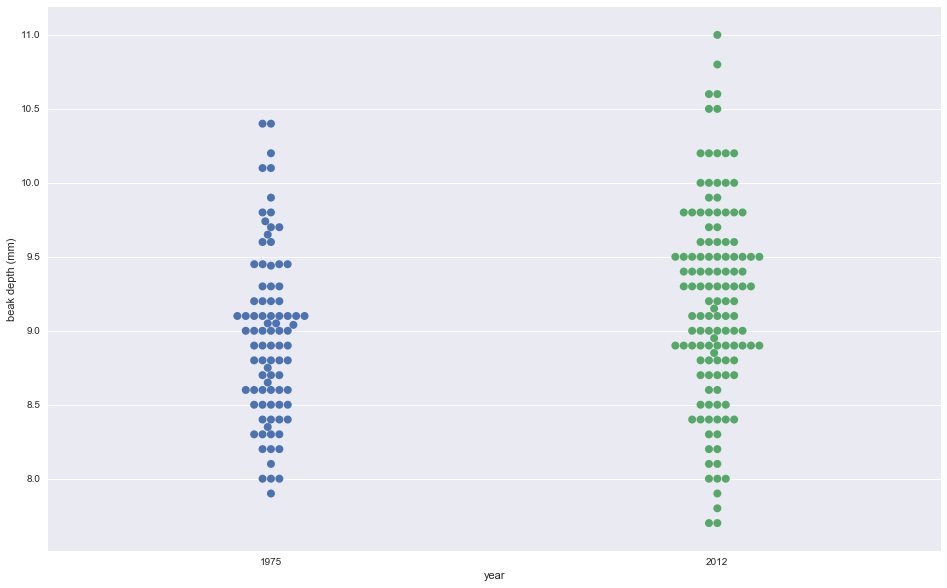

In [128]:
# Create bee swarm plot
plt.figure(figsize=(16,10))
p = sns.swarmplot(
    data = [bd_1975, bd_2012],
    size = 8)
p.set(xticklabels = ['1975','2012'])

# Label the axes

_ = plt.xlabel('year')
_ = plt.ylabel('beak depth (mm)')

# Show the plot
plt.show()

### ECDFs of beak depths

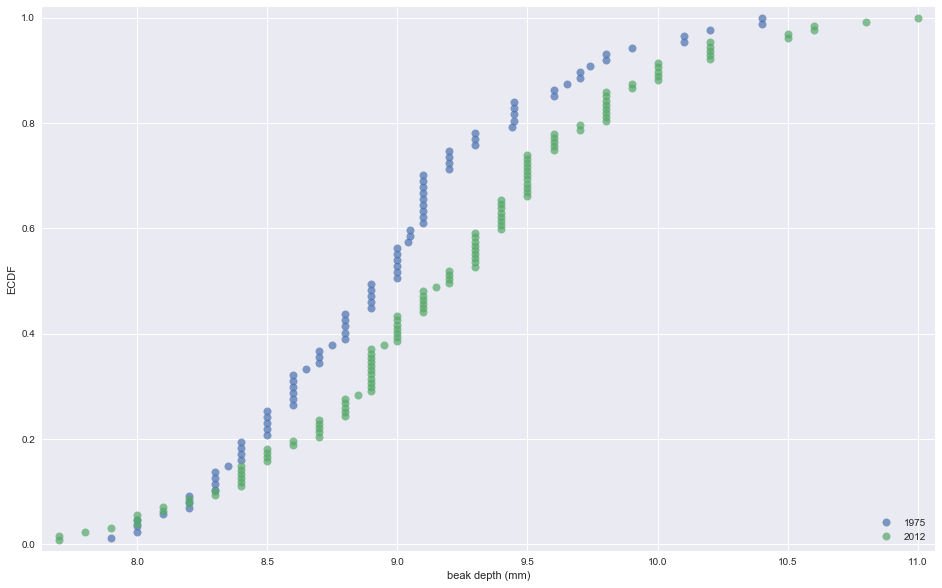

In [129]:
# Compute ECDFs
x_1975, y_1975 = ecdf(bd_1975)
x_2012, y_2012 = ecdf(bd_2012)

# Plot the ECDFs
plt.figure(figsize=(16,10))
plot_ecdf(x_1975, y_1975, size = 8)
plot_ecdf(x_2012, y_2012, size = 8)

# Set margins
plt.margins(0.02)

# Add axis labels and legend
_ = plt.xlabel('beak depth (mm)')
_ = plt.ylabel('ECDF')
_ = plt.legend(('1975', '2012'), loc='lower right')

# Show the plot
plt.show()

### Parameter estimates of beak depths

In [130]:
# Compute the difference of the sample means: mean_diff
mean_diff = np.mean(bd_2012) - np.mean(bd_1975)

# Get bootstrap replicates of means
bs_replicates_1975 = draw_bs_reps(bd_1975, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012, np.mean, 10000)

# Compute samples of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute 95% confidence interval: conf_int
conf_int = np.percentile(bs_diff_replicates, [2.5, 97.5])

# Print the results
print('difference of means =', mean_diff, 'mm')
print('95% confidence interval =', conf_int, 'mm')

difference of means = 0.226220472441 mm
95% confidence interval = [ 0.05927011  0.39225554] mm


### Hypothesis test: Are beaks deeper in 2012?

- Your plot of the ECDF and determination of the confidence interval make it pretty clear that the beaks of G. scandens on Daphne Major have gotten shallower. 
 - But is it possible that this effect is just due to random chance? 
 - In other words, what is the probability that we would get the observed difference in mean beak depth if the means were the same?
- Be careful! The hypothesis we are testing is not that the beak depths come from the same distribution. 
 - For that we could use a permutation test. 
 - The hypothesis is that the means are equal. 
 - To perform this hypothesis test, we need to shift the two data sets so that they have the same mean and then use bootstrap sampling to compute the difference of means.

In [131]:
# Compute mean of combined data set: combined_mean
combined_mean = np.mean(np.concatenate((bd_1975, bd_2012)))

# Shift the samples
bd_1975_shifted = bd_1975 - np.mean(bd_1975) + combined_mean
bd_2012_shifted = bd_2012 - np.mean(bd_2012) + combined_mean

# Get bootstrap replicates of shifted data sets
bs_replicates_1975 = draw_bs_reps(bd_1975_shifted, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012_shifted, np.mean, 10000)

# Compute replicates of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute the p-value
p = np.sum(bs_diff_replicates >= mean_diff) / len(bs_diff_replicates)

# Print p-value
print('p =', p)


p = 0.0028


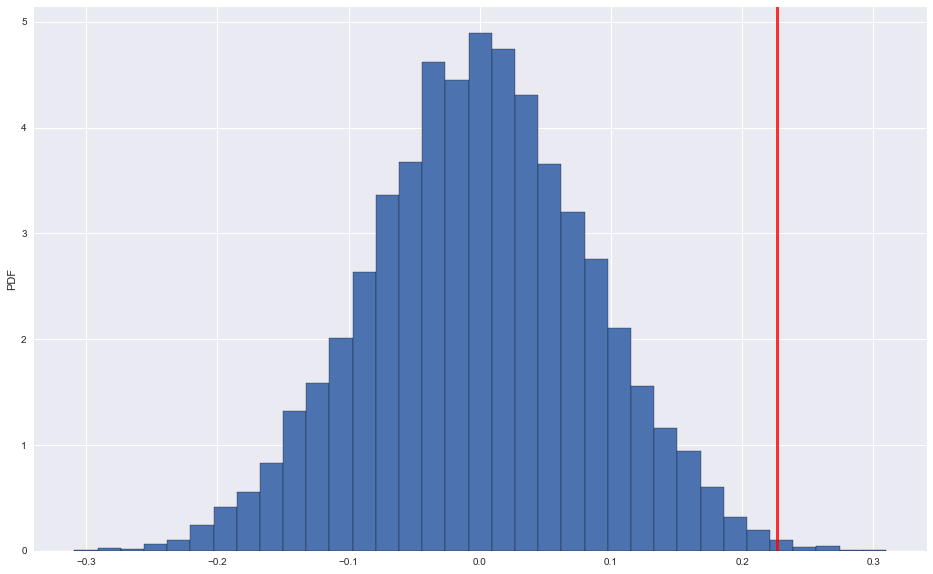

In [132]:
plot_hist_and_stat(bs_diff_replicates, mean_diff)
plt.show()

- So the beaks definitely got deeper
- Whats crazy is that I did this first with the 'fortis' species by accident and I saw statistical signifigant results showing the beak depth has gotten shallower. 
 - So the two species are becoming more differnet. 

## Variation of beak shapes

### EDA of beak length and depth

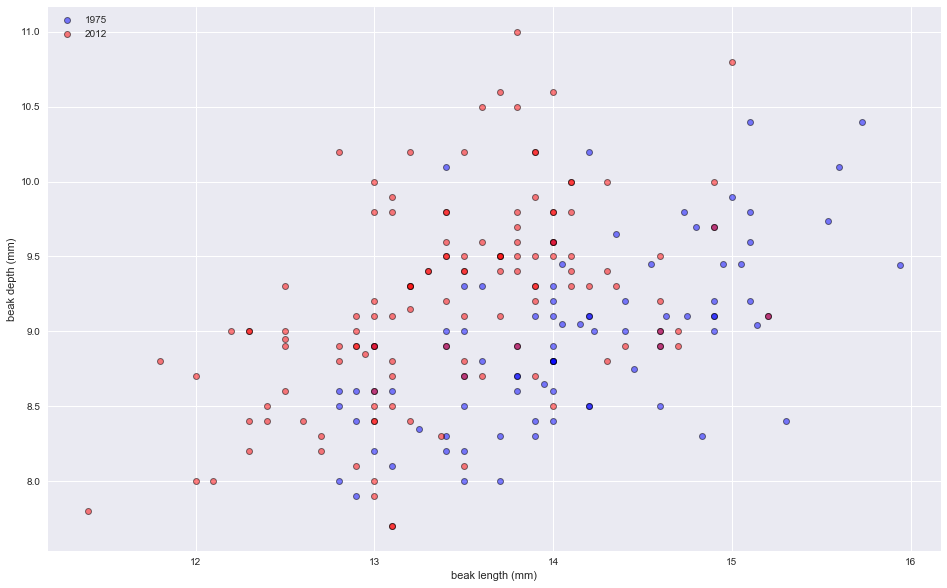

In [133]:
plt.figure(figsize=(16,10))

# Make scatter plot of 1975 data
_ = plt.plot(
    bl_1975, bd_1975, 
    marker='o',
    markersize = 6,
    markeredgewidth = 1,
    markeredgecolor = 'k',
    linestyle='none', 
    color = 'blue', 
    alpha = 0.5)

# Make scatter plot of 2012 data
_ = plt.plot(
    bl_2012, bd_2012, 
    marker='o',
    markersize = 6,
    markeredgewidth = 1,
    markeredgecolor = 'k',
    linestyle='none', 
    color = 'red', 
    alpha = 0.5)

# Label axes and make legend
_ = plt.xlabel('beak length (mm)')
_ = plt.ylabel('beak depth (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')

# Show the plot
plt.show()

### Linear regressions

In [134]:
print(np.sum(np.isnan(bl_1975)))
print(np.sum(np.isnan(bd_1975)))
print(np.sum(np.isnan(bl_2012)))
print(np.sum(np.isnan(bd_2012)))

0
0
0
0


In [135]:
print(len(bl_1975))
print(len(bd_1975))

87
87


In [149]:
np.array(bd_1975)

array([  8.4 ,   8.8 ,   8.4 ,   8.  ,   7.9 ,   8.9 ,   8.6 ,   8.5 ,
         8.9 ,   9.1 ,   8.6 ,   9.8 ,   8.2 ,   9.  ,   9.7 ,   8.6 ,
         8.2 ,   9.  ,   8.4 ,   8.6 ,   8.9 ,   9.1 ,   8.3 ,   8.7 ,
         9.6 ,   8.5 ,   9.1 ,   9.  ,   9.2 ,   9.9 ,   8.6 ,   9.2 ,
         8.4 ,   8.9 ,   8.5 ,  10.4 ,   9.6 ,   9.1 ,   9.3 ,   9.3 ,
         8.8 ,   8.3 ,   8.8 ,   9.1 ,  10.1 ,   8.9 ,   9.2 ,   8.5 ,
        10.2 ,  10.1 ,   9.2 ,   9.7 ,   9.1 ,   8.5 ,   8.2 ,   9.  ,
         9.3 ,   8.  ,   9.1 ,   8.1 ,   8.3 ,   8.7 ,   8.8 ,   8.6 ,
         8.7 ,   8.  ,   8.8 ,   9.  ,   9.1 ,   9.74,   9.1 ,   9.8 ,
        10.4 ,   8.3 ,   9.44,   9.04,   9.  ,   9.05,   9.65,   9.45,
         8.65,   9.45,   9.45,   9.05,   8.75,   9.45,   8.35])

- Be careful with the indexes
 - The `draw_bs_pairs_linreg` function uses the indexes.
 - I pulled these arrays from an indexed data frame based on a categorical value
 - I guess they should have the same index, but still, this is messing up the linreg process
 - making it a np array will drop the index
- was getting a nasty error
 -  "ValueError: On entry to DGELSD parameter number 4 had an illegal value"

In [155]:
# Compute the linear regressions
slope_1975, intercept_1975 = np.polyfit(bl_1975, bd_1975, 1)
slope_2012, intercept_2012 = np.polyfit(bl_2012, bd_2012, 1)

# Perform pairs bootstrap for the linear regressions
bs_slope_reps_1975, bs_intercept_reps_1975 = draw_bs_pairs_linreg(np.array(bl_1975), np.array(bd_1975), size = 1000)
bs_slope_reps_2012, bs_intercept_reps_2012 = draw_bs_pairs_linreg(np.array(bl_2012), np.array(bd_2012), size = 1000)

# Compute confidence intervals of slopes
slope_conf_int_1975 = np.percentile(bs_slope_reps_1975, [2.5, 97.5])
slope_conf_int_2012 = np.percentile(bs_slope_reps_2012, [2.5, 97.5])
intercept_conf_int_1975 = np.percentile(bs_intercept_reps_1975, [2.5, 97.5])
intercept_conf_int_2012 = np.percentile(bs_intercept_reps_2012, [2.5, 97.5])

# Print the results
print('1975: slope =', slope_1975,
      'conf int =', slope_conf_int_1975)
print('1975: intercept =', intercept_1975,
      'conf int =', intercept_conf_int_1975)
print('2012: slope =', slope_2012,
      'conf int =', slope_conf_int_2012)
print('2012: intercept =', intercept_2012,
      'conf int =', intercept_conf_int_2012)

1975: slope = 0.465205169161 conf int = [ 0.33350263  0.58739724]
1975: intercept = 2.39087523658 conf int = [ 0.6755014   4.24117169]
2012: slope = 0.462630358835 conf int = [ 0.33816447  0.5997382 ]
2012: intercept = 2.97724749824 conf int = [ 1.15962874  4.66543578]


### Displaying the linear regression results

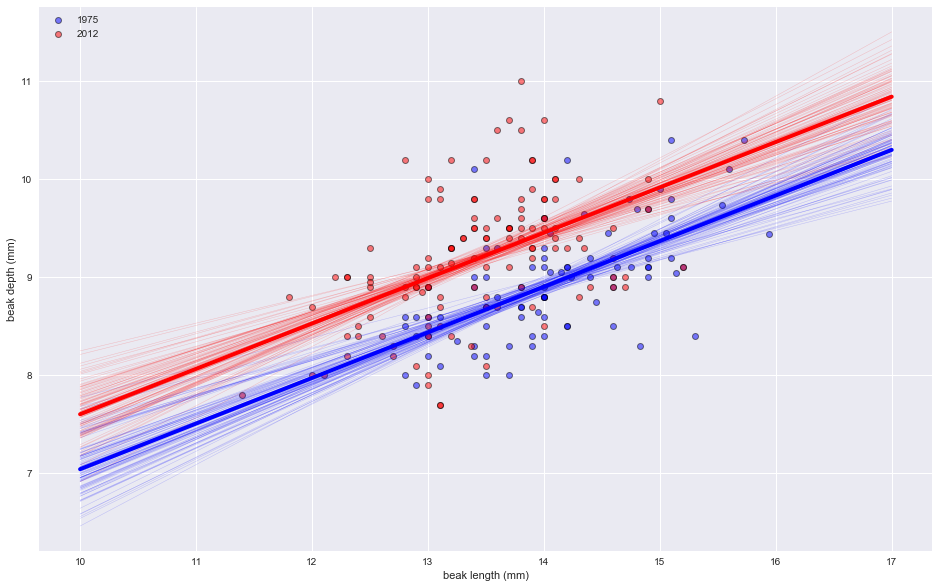

In [159]:
plt.figure(figsize=(16,10))

# Make scatter plot of 1975 data
_ = plt.plot(
    bl_1975, bd_1975, 
    marker='o',
    markersize = 6,
    markeredgewidth = 1,
    markeredgecolor = 'k',
    linestyle='none', 
    color = 'blue', 
    alpha = 0.5)

# Make scatter plot of 2012 data
_ = plt.plot(
    bl_2012, bd_2012, 
    marker='o',
    markersize = 6,
    markeredgewidth = 1,
    markeredgecolor = 'k',
    linestyle='none', 
    color = 'red', 
    alpha = 0.5)

# Label axes and make legend
_ = plt.xlabel('beak length (mm)')
_ = plt.ylabel('beak depth (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')

# Generate x-values for bootstrap lines: x
x = np.array([10, 17])

# Plot the bootstrap lines
for i in range(100):
    plt.plot(
        x, 
        bs_slope_reps_1975[i] * x + bs_intercept_reps_1975[i],
        linewidth=0.5, alpha=0.2, color='blue')
    plt.plot(
        x, 
        bs_slope_reps_2012[i] * x + bs_intercept_reps_2012[i],
        linewidth=0.5, alpha=0.2, color='red')
    
# Plot the original regression line
# Make theoretical line to plot
y_1975 = slope_1975 * x + intercept_1975
y_2012 = slope_2012 * x + intercept_2012

# Add regression lines to your plot
_ = plt.plot(x, y_1975, linewidth=4, color='blue')
_ = plt.plot(x, y_2012, linewidth=4, color='red')

# Draw the plot again
plt.show()

### Beak length to depth ratio

In [160]:
# Compute length-to-depth ratios
ratio_1975 = bl_1975/bd_1975
ratio_2012 = bl_2012/bd_2012

# Compute means
mean_ratio_1975 = np.mean(ratio_1975)
mean_ratio_2012 = np.mean(ratio_2012)

# Generate bootstrap replicates of the means
bs_replicates_1975 = draw_bs_reps(ratio_1975, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(ratio_2012, np.mean, 10000)

# Compute the 99% confidence intervals
conf_int_1975 = np.percentile(bs_replicates_1975, [0.5, 99.5])
conf_int_2012 = np.percentile(bs_replicates_2012, [0.5, 99.5])

# Print the results
print('1975: mean ratio =', mean_ratio_1975,
      'conf int =', conf_int_1975)
print('2012: mean ratio =', mean_ratio_2012,
      'conf int =', conf_int_2012)


1975: mean ratio = 1.57888237719 conf int = [ 1.55666868  1.60094451]
2012: mean ratio = 1.46583422768 conf int = [ 1.4439122   1.48805698]


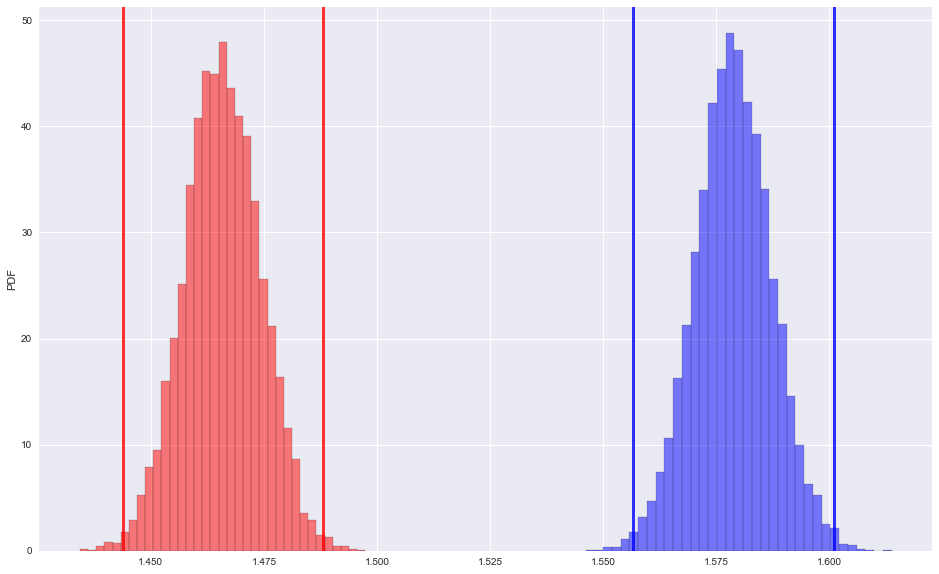

In [168]:
# Make a histogram of the results
plt.figure(figsize=(16,10))

## Plot 1975 bs replicates and conf ints
plt.hist(
    bs_replicates_1975, 
    color = 'blue',
    alpha = .5,
    edgecolor = 'k',
    bins = 35, 
    normed = True)

plt.axvline(
    x = conf_int_1975[0], 
    color = 'blue', 
    linewidth = 3, 
    alpha = .8)

plt.axvline(
    x = conf_int_1975[1], 
    color = 'blue', 
    linewidth = 3, 
    alpha = .8)

## Plot 2012 bs replicates and conf ints
plt.hist(
    bs_replicates_2012, 
    color = 'red',
    alpha = .5,
    edgecolor = 'k',
    bins = 35, 
    normed = True)

plt.axvline(
    x = conf_int_2012[0], 
    color = 'red', 
    linewidth = 3, 
    alpha = .8)

plt.axvline(
    x = conf_int_2012[1], 
    color = 'red', 
    linewidth = 3, 
    alpha = .8)

plt.ylabel('PDF')

plt.show()

### How different is the ratio?

- In the last exercise, you showed that the mean beak length to depth ratio was 1.58 in 1975 and 1.47 in 2012. 
 - The low end of the 1975 99% confidence interval was 1.56 mm 
 - The high end of the 99% confidence interval in 2012 was 1.49 mm. 
 - In addition to these results, what would you say about the ratio of beak length to depth?
- The mean beak length-to-depth ratio decreased by about 0.1, or 7%, from 1975 to 2012. 
 - The 99% confidence intervals are not even close to overlapping, so this is a real change. The beak shape changed.
- In this case we do not need to get a p-value. 
 - We could create a hypothesis test to test the real change vs a bunch of bootstrap changes or something
 - But we already know they are different. 
 - We would run the hypothesis to get a p-value if the confidence intervals overlapped and we wanted to see if the change was real or not. Here, we know its real

## Calculation of heritability

- Why are the beaks of scandens getting larger
- Maybe they are mating with the fortis
- Lets see how strongly the parental traits are passed on to offspring
 - We will look at this heredity trait in both species
- Heredity
 - The tendency for parental traits to be inherited by offspring

### EDA of heritability

In [170]:
file = 'https://assets.datacamp.com/production/course_1550/datasets/fortis_beak_depth_heredity.csv'
heridity_fortis = pd.read_csv(file)
heridity_fortis.head()

,Mid-offspr,Male BD,Female BD
0,10.70,10.90,9.3
1,9.78,10.70,8.4
2,9.48,10.70,8.1
3,9.60,10.70,9.8
4,10.27,9.85,10.4


In [174]:
heridity_fortis.iloc[:,[1,2]][:6]

,Male BD,Female BD
0,10.90,9.3
1,10.70,8.4
2,10.70,8.1
3,10.70,9.8
4,9.85,10.4
5,9.80,9.6


In [178]:
bd_parent_fortis = np.mean(heridity_fortis.iloc[:,[1,2]], axis = 1)
bd_parent_fortis[:6]

0    10.100
1     9.550
2     9.400
3    10.250
4    10.125
5     9.700
dtype: float64

In [179]:
bd_offspring_fortis = heridity_fortis.iloc[:,0]
bd_offspring_fortis[:6]

0    10.70
1     9.78
2     9.48
3     9.60
4    10.27
5     9.50
Name: Mid-offspr, dtype: float64

In [180]:
file = 'https://assets.datacamp.com/production/course_1550/datasets/scandens_beak_depth_heredity.csv'
heridity_scandens = pd.read_csv(file)
heridity_scandens.head()

,mid_parent,mid_offspring
0,8.3318,8.4190
1,8.4035,9.2468
2,8.5317,8.1532
3,8.7202,8.0089
4,8.7089,8.2215


In [181]:
bd_parent_scandens = heridity_scandens.iloc[:,0]
bd_offspring_scandens = heridity_scandens.iloc[:,1]

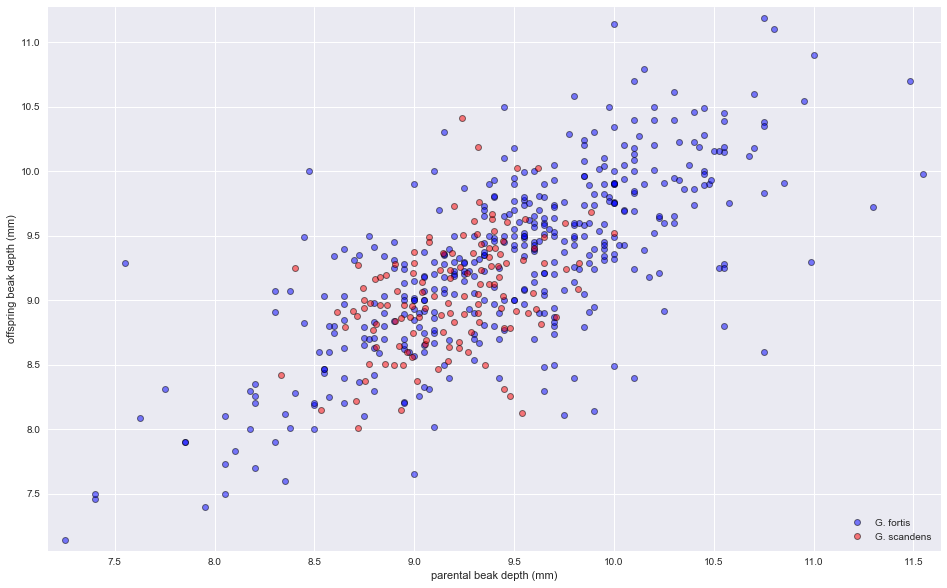

In [185]:
plt.figure(figsize=(16,10))

# Make scatter plots
_ = plt.plot(
    bd_parent_fortis, bd_offspring_fortis,
    marker='o',
    markersize = 6,
    markeredgewidth = 1,
    markeredgecolor = 'k',
    linestyle='none', 
    color = 'blue', 
    alpha = 0.5)

_ = plt.plot(
    bd_parent_scandens, bd_offspring_scandens,
    marker='o',
    markersize = 6,
    markeredgewidth = 1,
    markeredgecolor = 'k',
    linestyle='none', 
    color = 'red', 
    alpha = 0.5)

# Set margins
plt.margins(0.02)

# Label axes
_ = plt.xlabel('parental beak depth (mm)')
_ = plt.ylabel('offspring beak depth (mm)')

# Add legend
_ = plt.legend(('G. fortis', 'G. scandens'), loc='lower right')

# Show plot
plt.show()


### Correlation of offspring and parental data

- In an effort to quantify the correlation between offspring and parent beak depths, we would like to compute statistics, such as the Pearson correlation coefficient, between parents and offspring. 
- To get confidence intervals on this, we need to do a pairs bootstrap.

- You have already written a function to do pairs bootstrap to get estimates for parameters derived from linear regression. 
- Your task in this exercise is to modify that function to make a new function with call signature `draw_bs_pairs(x, y, func, size=1)` that performs pairs bootstrap and computes a single statistic on the pairs samples defined by `func(bs_x, bs_y)`. 
 - In the next exercise, you will use pearson_r for func.

In [198]:
def draw_bs_pairs(x, y, func, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)

    return bs_replicates

### Pearson correlation of offspring and parental data

In [199]:
# Compute the Pearson correlation coefficients
r_scandens = pearson_r(bd_parent_scandens, bd_offspring_scandens)
r_fortis = pearson_r(bd_parent_fortis, bd_offspring_fortis)

# Acquire 1000 bootstrap replicates of Pearson r
bs_replicates_scandens = draw_bs_pairs(
    bd_parent_scandens, 
    bd_offspring_scandens,
    pearson_r,
    1000)

bs_replicates_fortis = draw_bs_pairs(
    bd_parent_fortis, 
    bd_offspring_fortis,
    pearson_r,
    1000)


# Compute 95% confidence intervals
conf_int_scandens = np.percentile(bs_replicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(bs_replicates_fortis, [2.5, 97.5])

# Print results
print('G. scandens:', r_scandens, conf_int_scandens)
print('G. fortis:', r_fortis, conf_int_fortis)


G. scandens: 0.41170636294 [ 0.27478777  0.54048253]
G. fortis: 0.728341239552 [ 0.66554096  0.7840109 ]


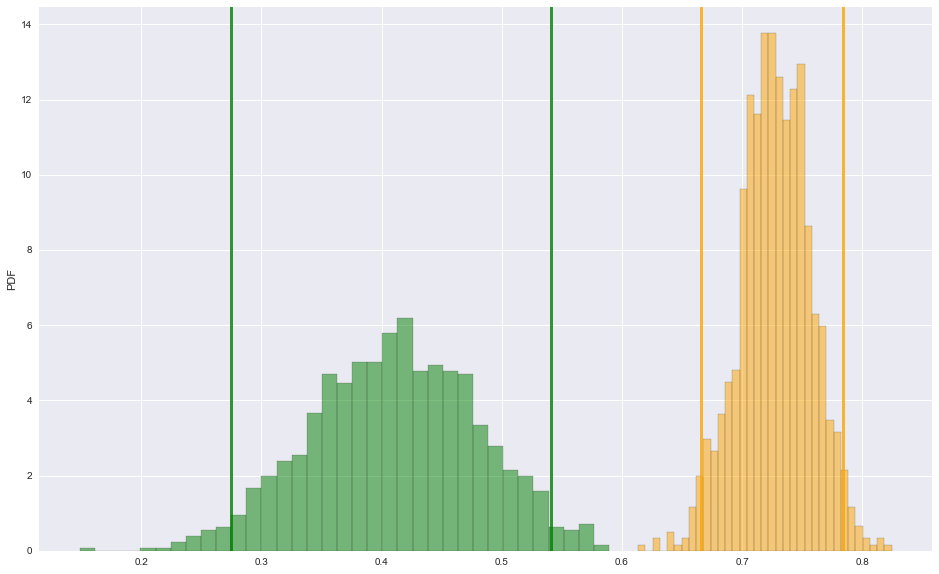

In [202]:
# Make a histogram of the results
plt.figure(figsize=(16,10))

## Plot scandens bs replicates and conf ints
plt.hist(
    bs_replicates_scandens, 
    color = 'green',
    alpha = .5,
    edgecolor = 'k',
    bins = 35, 
    normed = True)

plt.axvline(
    x = conf_int_scandens[0], 
    color = 'green', 
    linewidth = 3, 
    alpha = .8)

plt.axvline(
    x = conf_int_scandens[1], 
    color = 'green', 
    linewidth = 3, 
    alpha = .8)

## Plot fortis bs replicates and conf ints
plt.hist(
    bs_replicates_fortis, 
    color = 'orange',
    alpha = .5,
    edgecolor = 'k',
    bins = 35, 
    normed = True)

plt.axvline(
    x = conf_int_fortis[0], 
    color = 'orange', 
    linewidth = 3, 
    alpha = .8)

plt.axvline(
    x = conf_int_fortis[1], 
    color = 'orange', 
    linewidth = 3, 
    alpha = .8)

plt.ylabel('PDF')

plt.show()

- Wow, that is a fun plot,
- The sandens have quite a bit lower heritability it seams. While the fotis is quite hight and very tight also. 
- It almost seems like the scandens could possibly not have a statistical significant pearson correlation. 
 - Though it is above 0.2 so I would still say it does, its just weaker. We will test this in a bit

### Measuring heritability

Remember that the Pearson correlation coefficient is the ratio of the covariance to the geometric mean of the variances of the two data sets. This is a measure of the correlation between parents and offspring, but might not be the best estimate of heritability. If we stop and think, it makes more sense to define heritability as the ratio of the covariance between parent and offspring to the variance of the parents alone. In this exercise, you will estimate the heritability and perform a pairs bootstrap calculation to get the 95% confidence interval.

This exercise highlights a very important point. Statistical inference (and data analysis in general) is not a plug-n-chug enterprise. You need to think carefully about the questions you are seeking to answer with your data and analyze them appropriately. If you are interested in how heritable traits are, the quantity we defined as the heritability is more apt than the off-the-shelf statistic, the Pearson correlation coefficient.

In [203]:
def heritability(parents, offspring):
    """Compute the heritability from parent and offspring samples."""
    covariance_matrix = np.cov(parents, offspring)
    return covariance_matrix[0,1] / covariance_matrix[0,0]

# Compute the heritability
heritability_scandens = heritability(bd_parent_scandens, bd_offspring_scandens)
heritability_fortis = heritability(bd_parent_fortis, bd_offspring_fortis)

# Acquire 1000 bootstrap replicates of heritability
replicates_scandens = draw_bs_pairs(
        bd_parent_scandens, bd_offspring_scandens,
        heritability, size=1000)
        
replicates_fortis = draw_bs_pairs(
        bd_parent_fortis, bd_offspring_fortis,
        heritability, size=1000)


# Compute 95% confidence intervals
conf_int_scandens = np.percentile(replicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(replicates_fortis, [2.5, 97.5])

# Print results
print('G. scandens:', heritability_scandens, conf_int_scandens)
print('G. fortis:', heritability_fortis, conf_int_fortis)


G. scandens: 0.548534086869 [ 0.34515101  0.74670179]
G. fortis: 0.722905191144 [ 0.6426606   0.79034089]


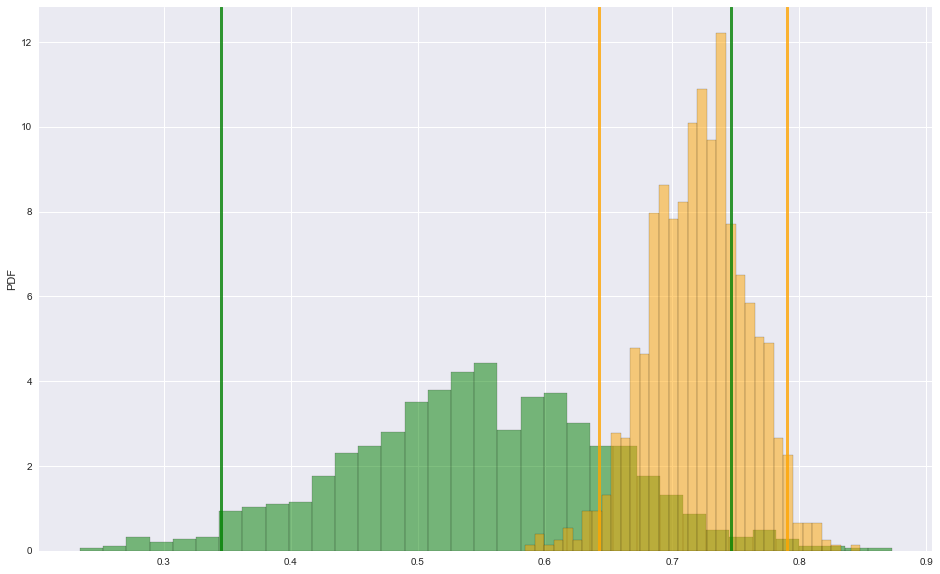

In [204]:
# Make a histogram of the results
plt.figure(figsize=(16,10))

## Plot scandens bs replicates and conf ints
plt.hist(
    replicates_scandens, 
    color = 'green',
    alpha = .5,
    edgecolor = 'k',
    bins = 35, 
    normed = True)

plt.axvline(
    x = conf_int_scandens[0], 
    color = 'green', 
    linewidth = 3, 
    alpha = .8)

plt.axvline(
    x = conf_int_scandens[1], 
    color = 'green', 
    linewidth = 3, 
    alpha = .8)

## Plot fortis bs replicates and conf ints
plt.hist(
    replicates_fortis, 
    color = 'orange',
    alpha = .5,
    edgecolor = 'k',
    bins = 35, 
    normed = True)

plt.axvline(
    x = conf_int_fortis[0], 
    color = 'orange', 
    linewidth = 3, 
    alpha = .8)

plt.axvline(
    x = conf_int_fortis[1], 
    color = 'orange', 
    linewidth = 3, 
    alpha = .8)

plt.ylabel('PDF')

plt.show()

- Here again, we see that G. fortis has stronger heritability than G. scandens. This suggests that the traits of G. fortis may be strongly incorporated into G. scandens by introgressive hybridization.
- But the overlap here is much more pronounced. The scandens data is much more spread out here

### Is beak depth heritable at all in *G. scandens*?

The heritability of beak depth in G. scandens seems low. It could be that this observed heritability was just achieved by chance and beak depth is actually not really heritable in the species. You will test that hypothesis here. To do this, you will do a pairs permutation test.

In [205]:
# Initialize array of replicates: perm_replicates
perm_replicates = np.empty(10000)

# Draw replicates
for i in range(10000):
    # Permute parent beak depths
    bd_parent_permuted = np.random.permutation(bd_parent_scandens)
    perm_replicates[i] = heritability(bd_parent_permuted, bd_offspring_scandens)


# Compute p-value: p
p = np.sum(perm_replicates >= heritability_scandens) / len(perm_replicates)

# Print the p-value
print('p-val =', p)


p-val = 0.0


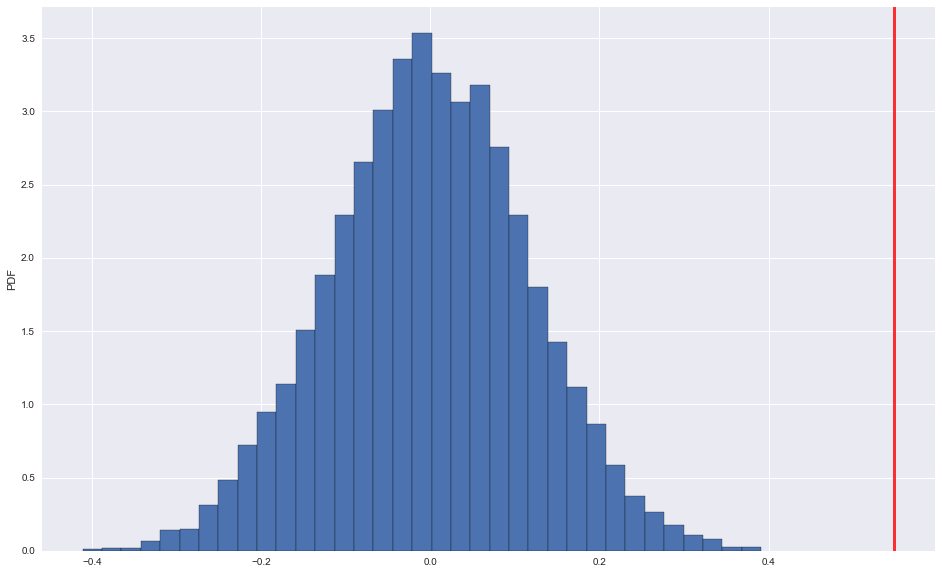

In [206]:
plot_hist_and_stat(perm_replicates, heritability_scandens)
plt.show()

You get a p-value of zero, which means that none of the 10,000 permutation pairs replicates you drew had a heritability high enough to match that which was observed. This strongly suggests that beak depth is heritable in G. scandens, just not as much as in G. fortis.